# Big Data Project-2

### Yash Kasundra
### ID- a1838670

## Covid-19 (cord dataset) create searching similarity tool

### Description

1. Collect and process pdf data dump from COVID-19 Open Research Dataset Challenge (CORD-19)
2.  Analyze the data and provide publication statistics such as the number of publications according to time, location but not limited to. Provide (any type of) visualization for the results.

3. Learn sentence embedding from the articles' abstract and main content respectively.

4. Build a tool for question answering: given a user input sentence or query, outputs the top 10 most relevant sentences from the data and the source of the data, i.e., the sentence comes from which article.  The tool could be command-line based or a simple Web-based interface. 

credits: University of Adelaide (4120_COMP_SCI_7209)

#### Dataset can be Found on Kaggle using this link:  

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

#### Note: This is the second notebook for this project in order for this notebook to work you need to run 1st notebook and put its output file into same working folder as this one.


## 1. Exploratory Data Analysis

#### Please use this commands if any of the below libraries are not installed on your pc/laptop

    !pip install wordcloud
    !pip install nltk
    !pip install spicy
    !pip install seaborn
    !pip install numpy
    !pip install pandas
    !pip install sklearn
    !pip install tensorflow
    !pip install sent2vec
    !pip install sentence-transformers
    !pip install gensim
    !pip install torch

### 1.1 Loading python libraries

In [1]:
%matplotlib inline
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
import re #regular expression to find special character sequence
import csv

import math
import string
import gc # Garbage Collector
import shutil
import tensorflow as tf
import torch

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# WordCloud:- Cloud filled with lots of words in different sizes, which represent the frequency or the importance of each word
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

color = sns.color_palette()

# The Natural Language Toolkit, or more commonly NLTK, 
# is a suite of libraries and programs for symbolic and statistical natural language processing (https://www.nltk.org)
from nltk.stem import  WordNetLemmatizer 
# from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from scipy.spatial import distance
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow import keras
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec
import gensim

from sentence_transformers import SentenceTransformer , util

In [2]:
import nltk # https://www.nltk.org you can find different packages to download here
nltk.download('popular')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |   

### 1.2 Loading data and printing basic stats

In [3]:
df = pd.read_csv('.\Data\covid_data.csv')

In [4]:
df.head()

,cord_uid,title,abstract,publish_time,authors,journal,pdf_json_files,pmc_json_files,url,body_text
0,emd6te1x,Religious Education in Catholic Schools: Troub...,Does Religious Education have a future? It cou...,2020-11-07,"Dineen, Fiona",Irish and British Reflections on Catholic Educ...,document_parses/pdf_json/4ea7c6a0db4dff676b5c2...,document_parses/pmc_json/PMC7980965.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Introduction: Setting the Scene\n\nIn the past...
1,wnnfcc01,Die Wirtschaftspolitik zurückgewinnen,"Die genauere Analyse in diesem Kapitel zeigt, ...",2021-02-23,"Oberholzer, Basil",Die globale Armut bek&#x000e4;mpfen,document_parses/pdf_json/b5c562cc1b54f4e6ca3c5...,document_parses/pmc_json/PMC7972609.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,\n\neinem Land den notwendigen Raum für seine ...
2,gn2bwgt2,Maternal and neonatal data collection systems ...,BACKGROUND: Most post-licensure vaccine pharma...,2021-03-17,"Berrueta, Mabel; Ciapponi, Agustin; Bardach, A...",BMC Pregnancy Childbirth,document_parses/pdf_json/ccf579bc93d39ce33e3eb...,document_parses/pmc_json/PMC7968860.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33731029/;...,Background\n\nSpontaneous or passive reporting...
3,4ueeiewe,Romiplostim in children with newly diagnosed o...,Immune thrombocytopenia (ITP) is a disease of ...,2021-07-26,"Grainger, John D.; Kühne, Thomas; Hippenmeyer,...",Ann Hematol,document_parses/pdf_json/caecb12b9188ee33c3b49...,document_parses/pmc_json/PMC8310729.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/34308495/;...,Introduction\n\nPrimary immune thrombocytopeni...
4,evhj17n7,Psychological Impact on the Nursing Profession...,Background: The COVID-19 pandemic is a public ...,2021-01-12,"Del Pozo-Herce, Pablo; Garrido-García, Rebeca;...",Int J Environ Res Public Health,document_parses/pdf_json/48d82b7161254e4dc4f39...,document_parses/pmc_json/PMC7827934.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33445563/;...,"Introduction\n\nIn December 2019, the first ou..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7985 entries, 0 to 7984
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cord_uid        7985 non-null   object
 1   title           7985 non-null   object
 2   abstract        7985 non-null   object
 3   publish_time    7985 non-null   object
 4   authors         7985 non-null   object
 5   journal         7985 non-null   object
 6   pdf_json_files  7985 non-null   object
 7   pmc_json_files  7985 non-null   object
 8   url             7985 non-null   object
 9   body_text       7985 non-null   object
dtypes: object(10)
memory usage: 624.0+ KB


#### Checking if there are any null values at all

In [6]:
df.isnull().sum()

cord_uid          0
title             0
abstract          0
publish_time      0
authors           0
journal           0
pdf_json_files    0
pmc_json_files    0
url               0
body_text         0
dtype: int64

#### Checking if there are any duplicates present

In [7]:
df.duplicated(subset={"title","abstract","body_text"}).value_counts()

False    7985
dtype: int64

### 1.3 Checking few graphs to understand the data sets

In [8]:
dates = df['publish_time'].unique()
count = df['publish_time'].value_counts()
print(dates)
print(count)

['2020-11-07' '2021-02-23' '2021-03-17' ... '2017-07-13' '2018-01-15'
 '2018-03-12']
2021-07-15    33
2021-04-29    31
2021-01-06    30
2021-06-30    29
2021-03-08    28
              ..
2005-06-17     1
2017-08-15     1
2005-11-02     1
2016-10-22     1
2004-03-17     1
Name: publish_time, Length: 1895, dtype: int64


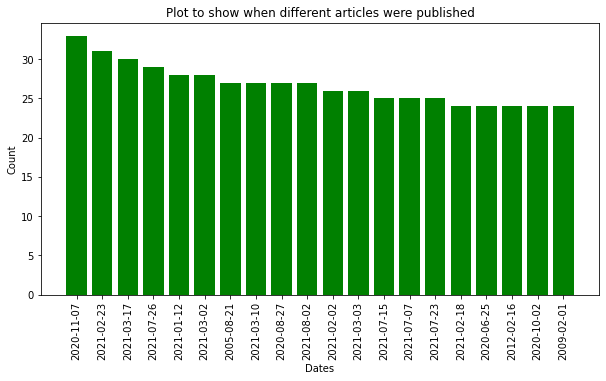

In [9]:
plt.rcParams["figure.figsize"]=10,5
# Only Checking top 20 publications for a month since whole plot can't be read properly 
plt.bar( dates[:20], count[:20], color = "green")
plt.xlabel("Dates")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.title("Plot to show when different articles were published")
plt.show()

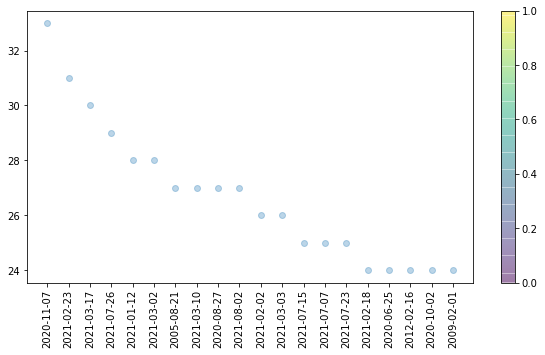

In [10]:
x = dates
y = count

plt.scatter(x[:20], y[:20], alpha=0.3,
            cmap='viridis')
plt.xticks(rotation = 90)
plt.colorbar();  # show color scale

__Observation__:

    1) So as we can see from both these plots, at max there were 33 articles published in 2020-11-07 and least there is 1 article in a month. Most of the articles were published after the pandemic began.

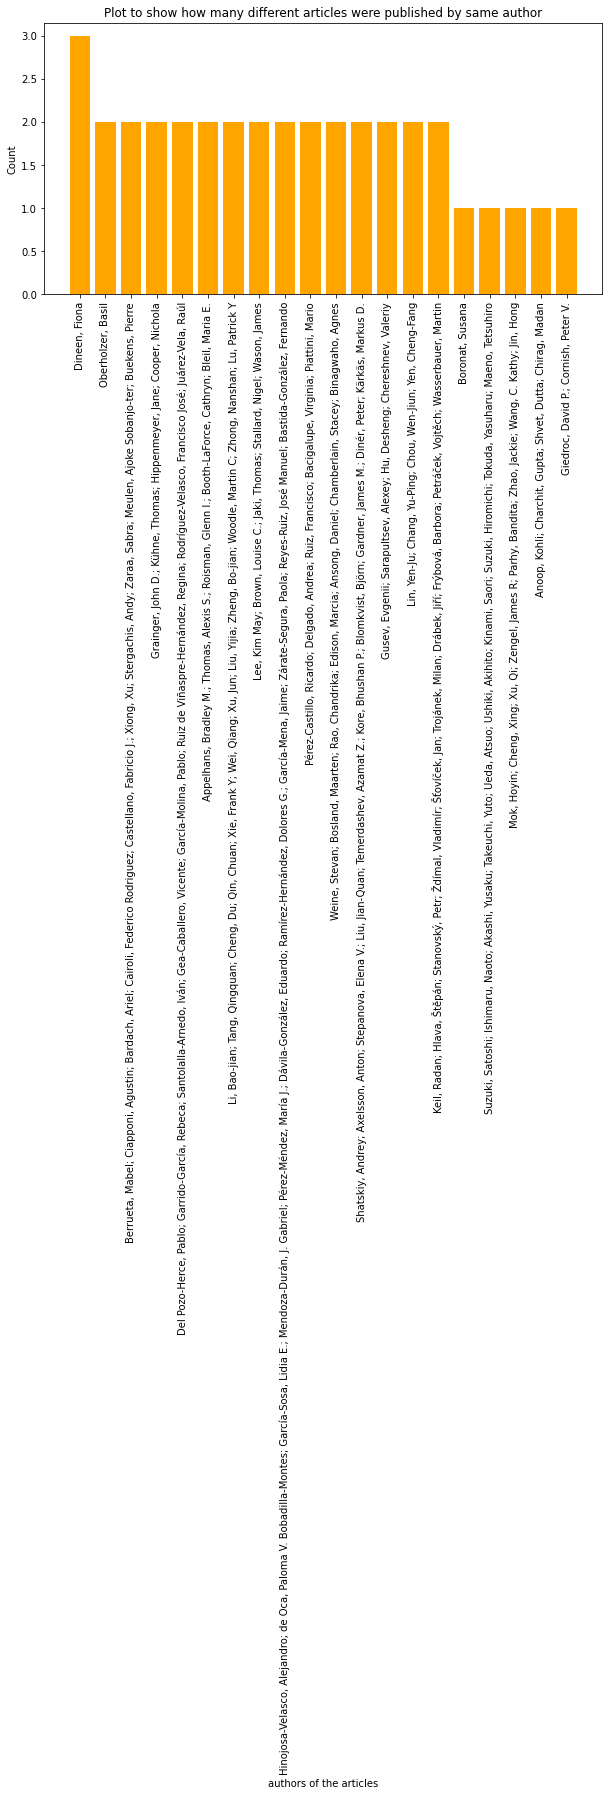

In [11]:
# Number of Articles by same authors

authors = df['authors'].unique()
freqs = df['authors'].value_counts()

plt.rcParams["figure.figsize"]=10,5

# Only Checking top 20 authors 
plt.bar( authors[:20], freqs[:20], color = "orange")
plt.xlabel("authors of the articles")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.title("Plot to show how many different articles were published by same author")
plt.show()

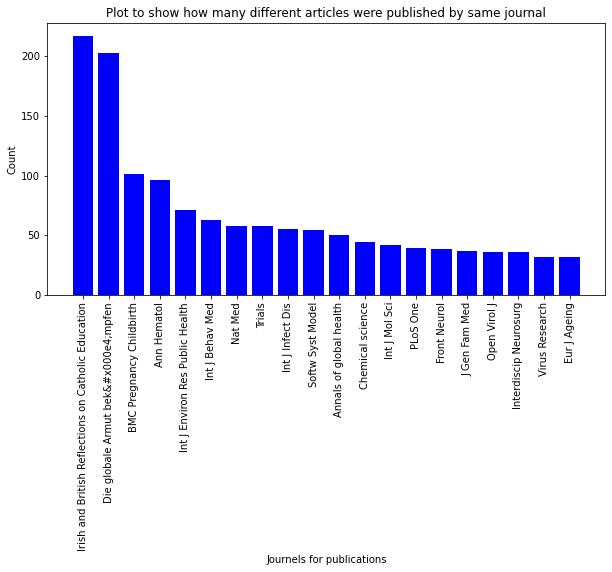

In [12]:
# Number of Articles by same publications journal

journal = df['journal'].unique()
freqs = df['journal'].value_counts()

plt.rcParams["figure.figsize"]=10,5

# Only Checking top 20 authors 
plt.bar( journal[:20], freqs[:20], color = "blue")
plt.xlabel("Journels for publications")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.title("Plot to show how many different articles were published by same journal")
plt.show()

In [13]:
# Using all these functions from project-1
def wordcloud_display(text_data, title):

    # Taking all unique data and storing it in a list
    words_list = text_data.unique().tolist()
    # Joining all these words togather to into wordcloud function
    words = ' '.join(words_list)
    
    # To create a collage of words form input
    wordcloud = WordCloud(width = 800, height = 400,
                      stopwords = set(STOPWORDS)).generate(words)

    plt.figure(figsize=(20, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f'Words in {title}')
    plt.axis("off")
    plt.show()

#### 1.4 Plotting wordclouds for few columns

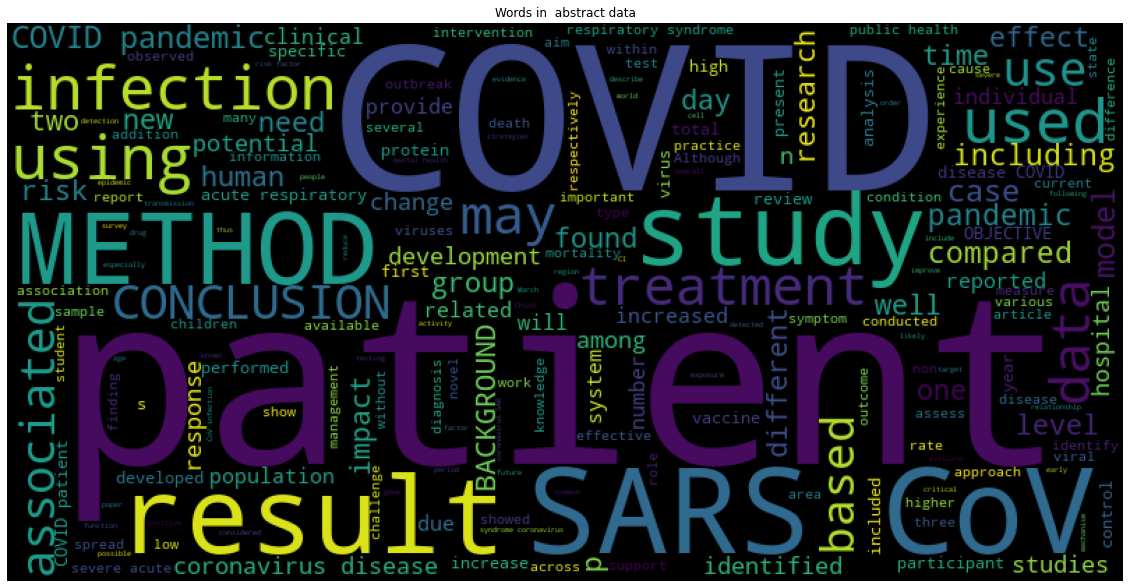

In [14]:
# Wordcloud for abstract
wordcloud_display(df['abstract'], ' abstract data')

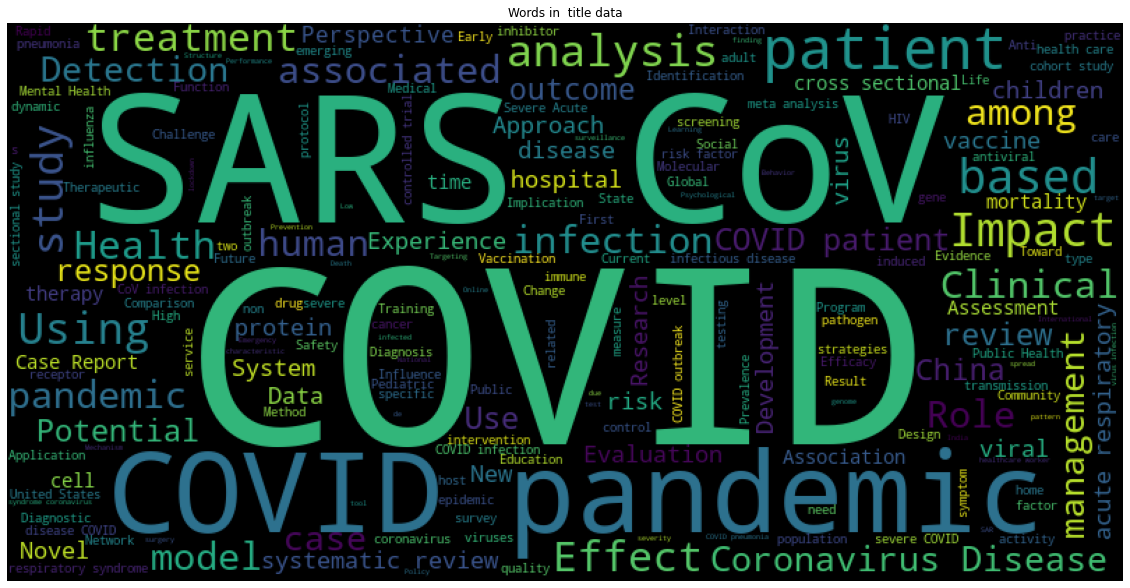

In [15]:
# Wordcloud for titles
wordcloud_display(df['title'], ' title data')

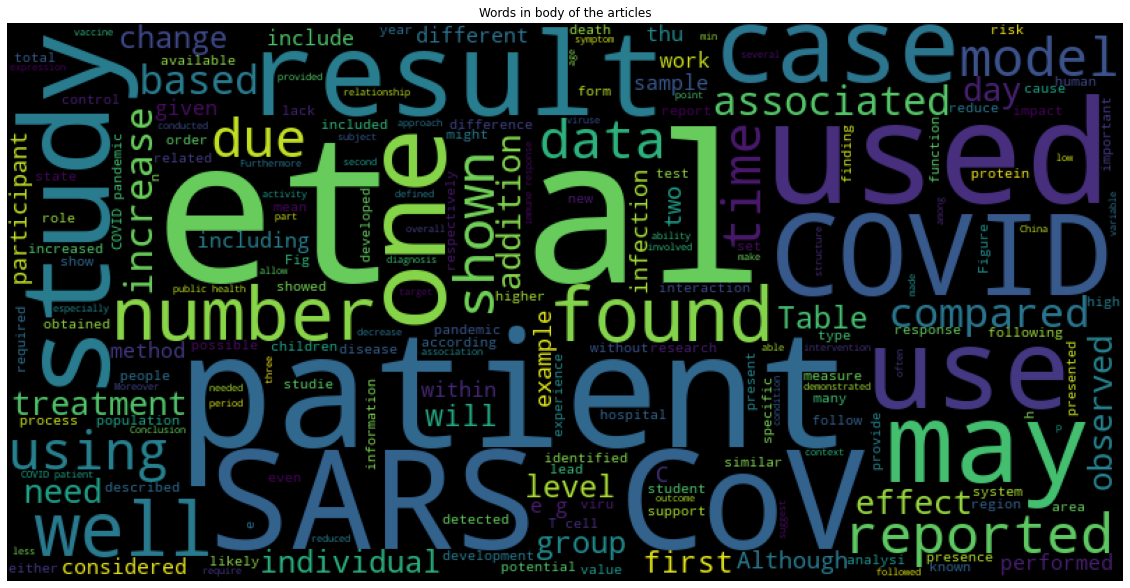

In [16]:
# Wordcloud for titles
wordcloud_display(df['body_text'], 'body of the articles')

### 1.5 Most Frequent words in both abstract and bodytext (Unigrams (1 word ) | Bigrams (2 words) | Trigrams (3 words) ) Before pre-processing

Using all these functions from project-1

In [17]:
def word_freq_plot(data, title, bar_color):
    
    # taking only 25 most used words 
    frequent_words = Counter(data).most_common(25)
    # Storing these words and their counts in a data frame and sorting these values based on their count
    df_words = pd.DataFrame(frequent_words, columns=['word', 'count']).sort_values('count')

    # Plotting a bar graph based on the data
    plt.barh(df_words['word'].values, df_words['count'].values, orientation='horizontal', color=bar_color) # plot
    plt.title(f'Top words in {title}')

__Stopwords:__
- Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc
- Thus we will be not considering those words

In [18]:
# Function to retrieve single words from question text
def get_unigrams(data):
    unigrams = []
    
    # Running a loop to separate/split the question text into single words and filtering stopwords
    for words in data:
        unigrams.extend([w for w in words.lower().split() if w not in STOPWORDS])
    return unigrams

# Function to retrieve pairs of 2 words from question text
def get_bigrams(data):
    bigrams = []
    
    # Running a loop to separate/split the question text into 2 words and filtering stopwords
    for words in data:
        words = [w for w in words.lower().split() if w not in STOPWORDS]
        bi = [b for b in nltk.bigrams(words)]
        bi = [' '.join(w) for w in bi]
        bigrams.extend(bi)
    return bigrams

# Function to retrieve pairs of 3 words from question text
def get_trigrams(data):
    trigrams = []
    
    # Running a loop to separate/split the question text into 3 words and filtering stopwords
    for words in data:
        words = [w for w in words.lower().split() if w not in STOPWORDS]
        tri = [t for t in nltk.trigrams(words)]
        tri = [' '.join(w) for w in tri]
        trigrams.extend(tri)
    return trigrams

In [19]:
# Creating data frames of unigram, bigram, trigram with sincere and insincere questions

# Unigrams
unigrams_abstract  = get_unigrams(df['abstract'])
unigrams_body = get_unigrams(df['body_text'])

# Bigrams
bigrams_abstract = get_bigrams(df['abstract'])
bigrams_body = get_bigrams(df['body_text'])

# Trigrams
trigrams_abstract = get_trigrams(df['abstract'])
trigrams_body = get_trigrams(df['body_text'])

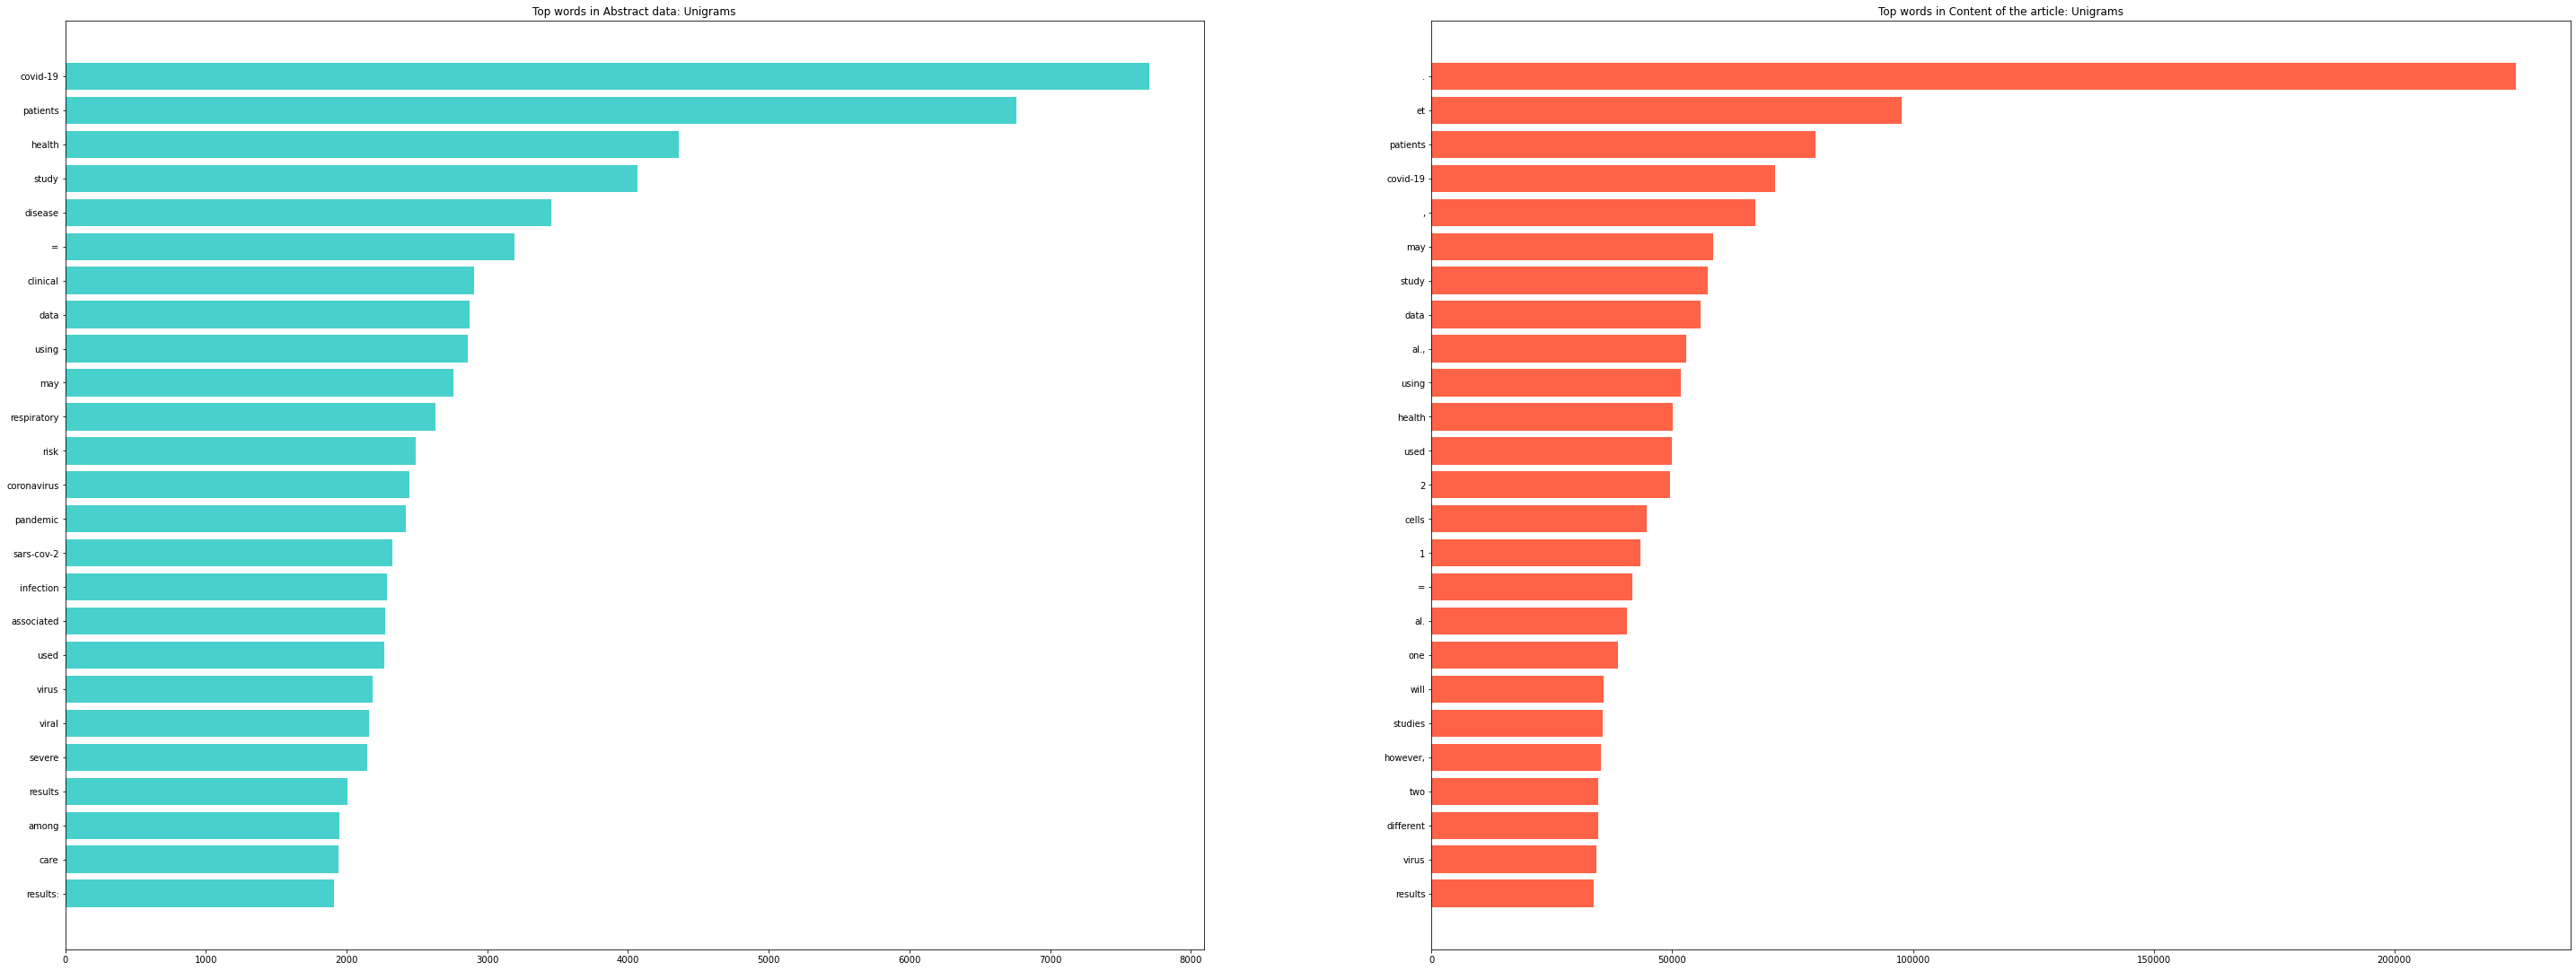

In [20]:
# plotting graph of Unigrams Sincere words 
plt.subplot(1, 2, 1)
word_freq_plot(unigrams_abstract, 'Abstract data: Unigrams', 'mediumturquoise')

# plotting graph of Unigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(unigrams_body, 'Content of the article: Unigrams', 'tomato')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

__Observation__:
- After taking a closer look it seems we would need to clean the data first to get better accuracy, plus I also discovered that most words are related to covid, disease, health etc and it is obvious since data set is related to covid. We'll know more after cleaning, now lets check few word phrases that are common 

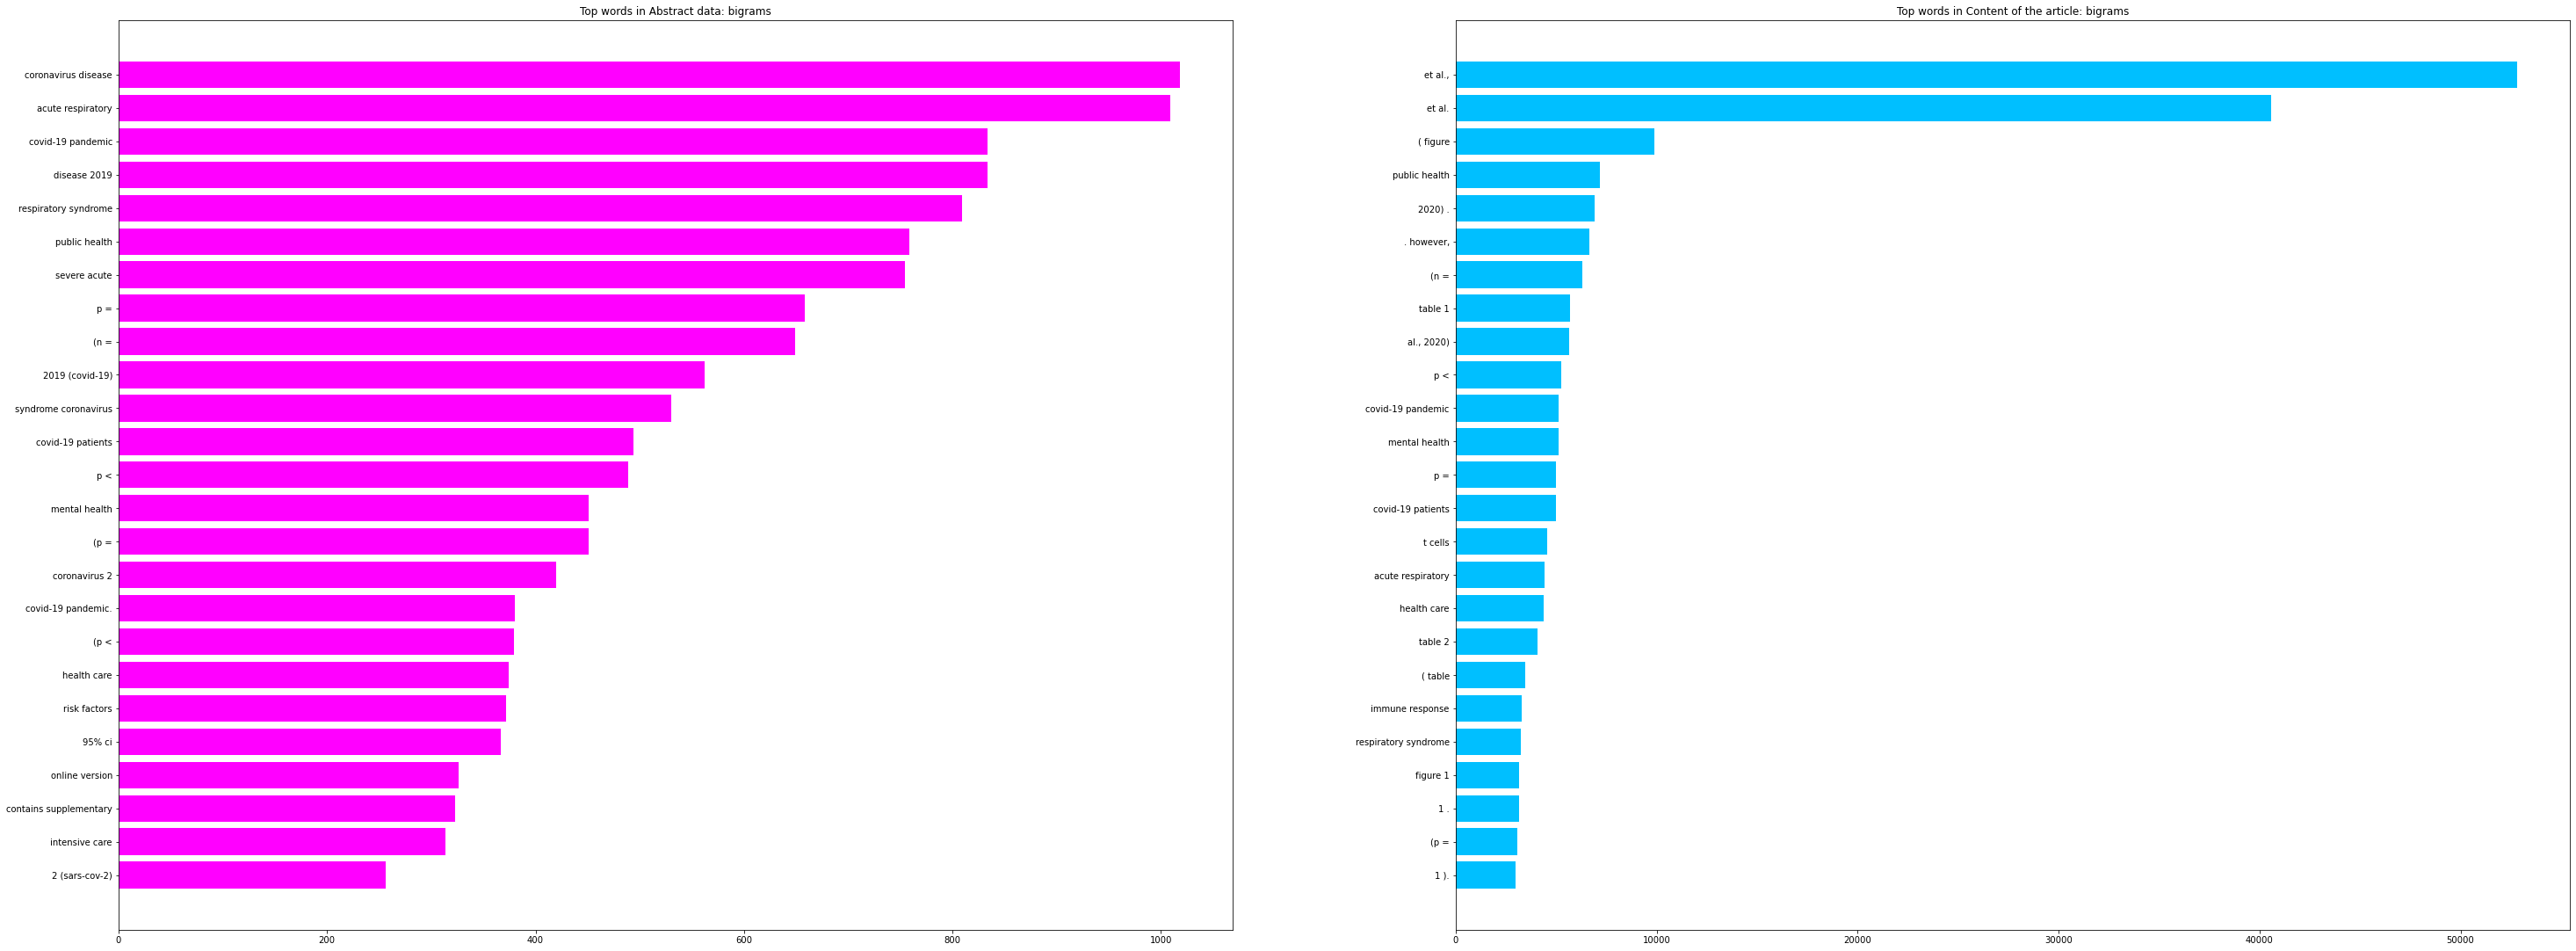

In [21]:
# plotting graph of Bigrams Sincere words
plt.subplot(1, 2, 1)
word_freq_plot(bigrams_abstract, 'Abstract data: bigrams', 'magenta')

# plotting graph of Bigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(bigrams_body, 'Content of the article: bigrams', 'deepskyblue')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

__Observation__:
- It looks like there are lot of mathematical formulas involved and some statistics plus probabilities, so we would need to handle those as well.

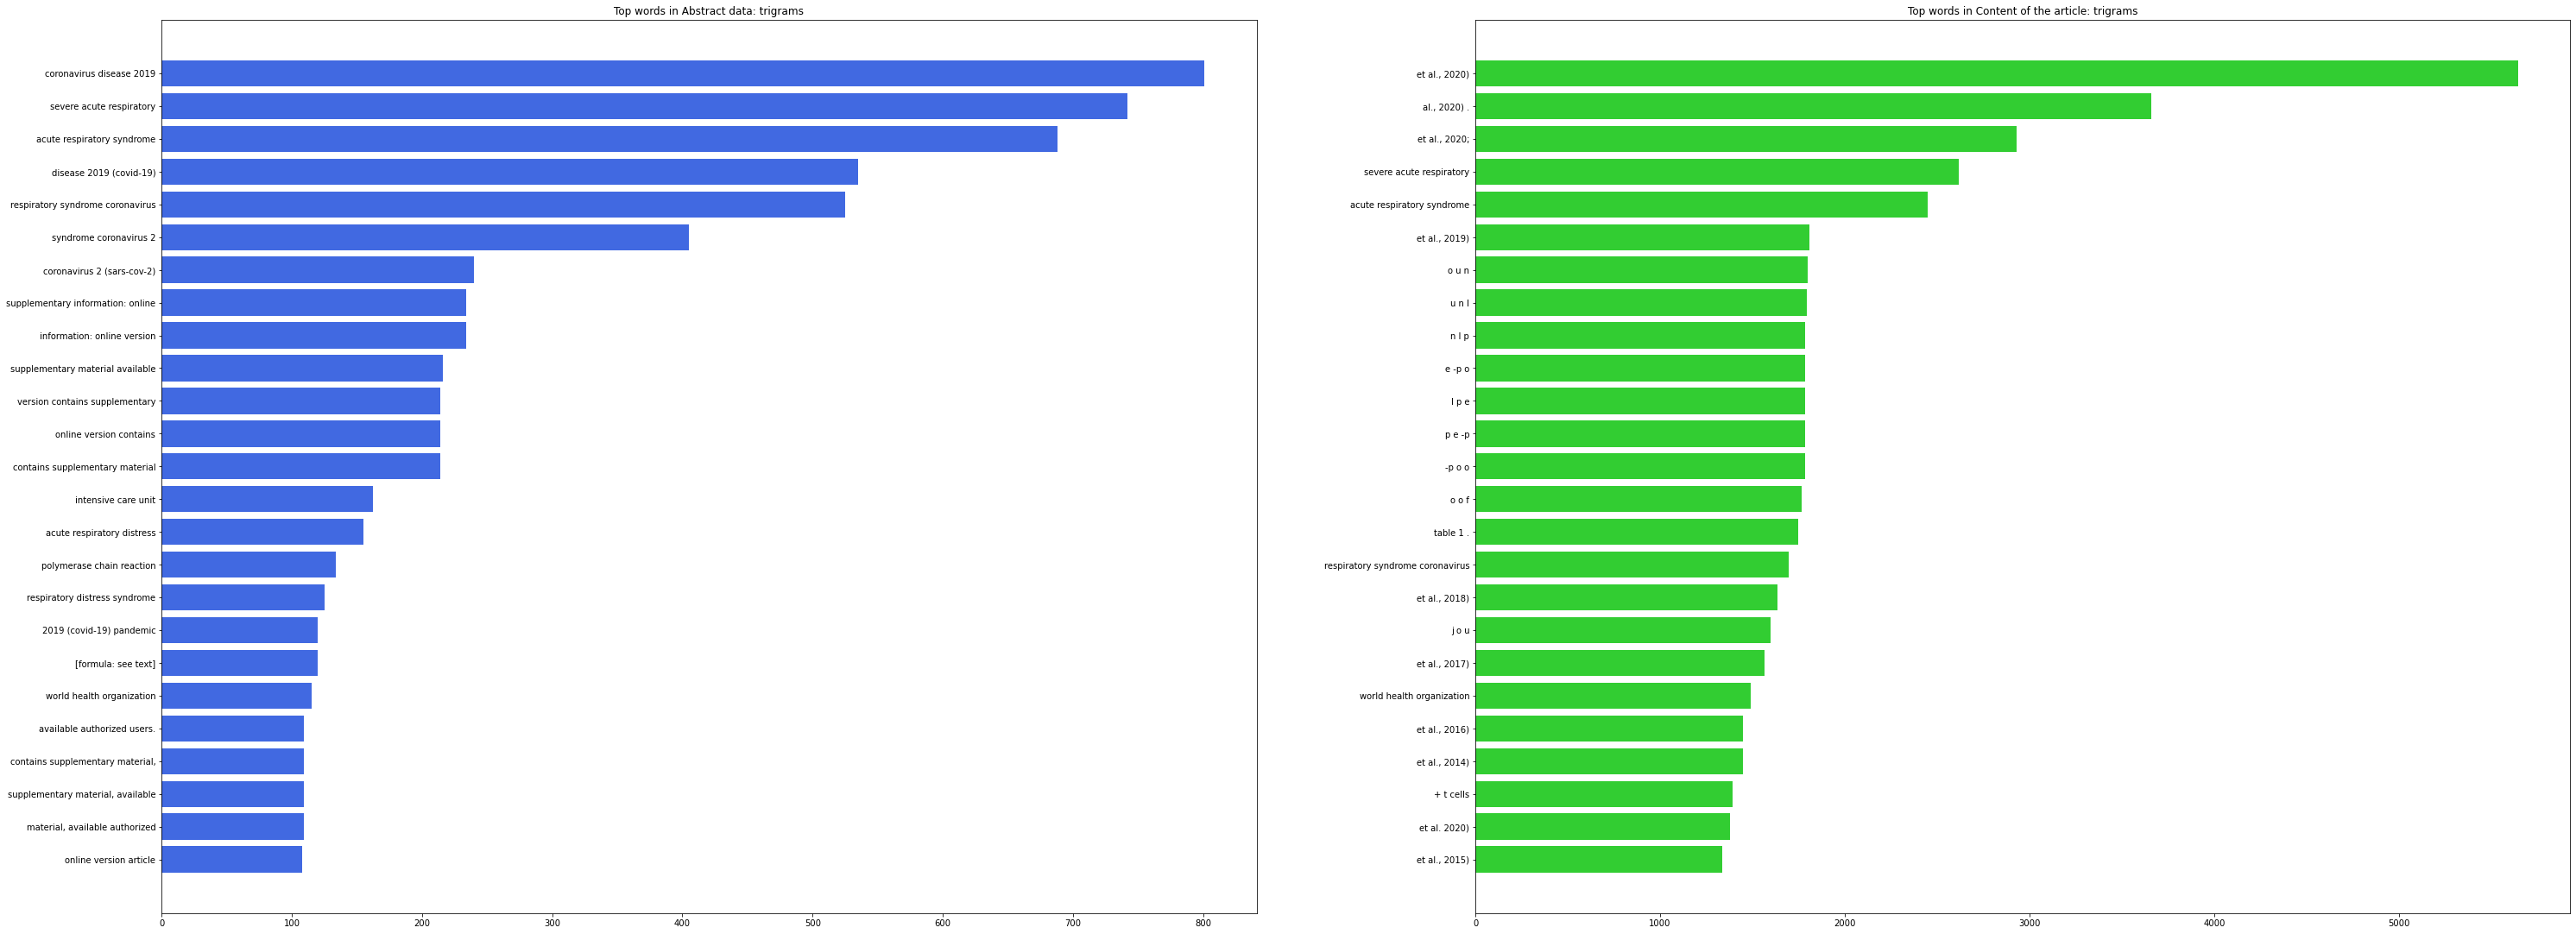

In [22]:
# plotting graph of Trigrams Sincere words
plt.subplot(1, 2, 1)
word_freq_plot(trigrams_abstract, 'Abstract data: trigrams', 'royalblue')

# plotting graph of Trigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(trigrams_body, 'Content of the article: trigrams', 'limegreen')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

__Observation__:
- This data needs to be cleaned since all you can see in body text plot is formulas and numbers in most parts of these 3 plots

### 1.6 Check how many different punctuation marks and symbols are present in the abstract and body text columns

In [23]:
# Returns a set with all symbols used in questions asked on quora data set (from project-1)
def retrieve_symbol(data):
    """
    Returns SET: special symbols in corpus
    """
    # Initializing empty set/array to store values
    symbols = []
    for text in data:
        # Using Regular expression library getting all special characters from question texts
        s = re.findall(r'\W+', str(text))
        # Then appending all such special chars to our set/array
        symbols.extend(s), 
        
    return set(symbols)

In [24]:
spec_chars = retrieve_symbol(df['abstract'].values)
print(spec_chars)

{'}-', '≤.', ' (−/−) ', '%, ', ' ≈ ', '", "', ' (€', ')”, “', ' % ', '] = ', ')/', '% “', ' = -', '.’', ', €', '., ≥ ', '™ – ', ' %)]. ', ';', '’=−', ' + ~ ', '.’ ', '$ ', ' £', '(+)- ', ')”, ', ' "', ', “-', ' – ', ' \xad', ')] (', '+)) ', '?” (', '%; ', ') ˃', ' · ', '%. (', ')-, ', '))). ', '(−/−)) ', ']:', '-‘', '† ', '’, ', '+/−', '±', ',” ', '∆', ')×', ']; ', ' (= -', '(-/-)→', ' #', '. ≤ ', '“ (', ' -: ', ': − ', ')]. ', ') = .', ' (+/+), ', '))) ', ' ⩾', '%, (', '] $', ' −', '"', ')·', ' (∗)', ' ≥', ' „', ')>. ', ',(', ' ∼ ', '−). ', '’ ', ') - ', ']); ', '-/', ']. (', ').. ', ')<', '’; ', '% ≥ ', '%). • ', '‐', ' ( − ', ')% ', '” – ', '/), ', '): ', ' =-.', ' % [', '~', '%)', '.,]. ', '(∗)', ': −.', '])) ', "' “", '’. ', ' )≥', '-(', '® ', ' (+/+)), ', '(,) , ', ' | ', ' –', ', -', '% ≥', ' =', ') (~ ', '.) ', ', ~', ']}, ', ').', ' +/- ', '(-/-)) ', ', .', ' )= ', ') < ', '], [', '(+)-', '’: ', '%): ', '; • ', ': . ', '′>', ' > .', '%)] ', ')) ', ')[', ') = - ', '% ± ', ' ‘',

In [25]:
spec_chars = retrieve_symbol(df['body_text'].values)
print(spec_chars)

{' );', ' ++ ) ', '|) ', ' ( , ) ( ) ', ' ⊥ )/(', '" ([', ' )̃(', ' < < < ', ' [␣] + ', ' ) .\n\n', ' | [ ', ']) = ', '; ***: ', '] :• ', ' ~−', ') = ∅. ', '•••', ' ⇆ ', '):" ', ' <, ;̃$ − :̃', ' -−.', ' % \\', ' (**)\n\n', '\uf061 (', '− . ', '/ . ', '.© ', ' ′ > ', '….…………………………….........', ' - - - -', '" " ', ' ∼<', ' ⇓ ', ') ., ', '))) ', ' , -', ') -(', '.--', '] : \n\n', ' © (', '>.\n\n', ') : {', '/... ', ' | −', ')-(+)', ')." ', '% < ', ' | " | ', '™ [', '. [ \n\n', ' ( \n\n', '?" … ', ' ] |(', "…'", '′,', ': "-', ' °. ', '.\n\n« ', ', ** ', ' ( ) + ', '® ', '%)); ', ")?'; '", '; & ', '(). ', ' ; …; ', '. \n\n•\n\n', '., > ', ' ) < ', '--) (', ', "[', ' − −', ') : [−', '+/ ', " (' ", ':[{"*', ') .\n\n| ', '))) ≤ ', ' %" ) ', '^) ', ', ...). ', ' − $', ' ), [', '. . . ', '^).^^ ', ' (%', '. ***', '®, ', '?\'; \'"', '?," ', ': @, ', '). {', ' ′ . ', ' ¢ [', '?; ', " (' {", '−[', ' #: ', '+ ]', '……………….……………………………………. ', '. …; ', ' (?) ', '̂+', ' < +∞ ', '----(', '␥', '. ( , ', ' 

## 2. Data Preprocessing and cleaning

### 2.1 Creating functions for these tasks
- Replacing math equations and url's with common abbrevation.
- Cleaning contractions.
- Spelling Correction.
- Removing punctuations.
- Removing Stopwords.
- Using WordNet Lemmatizer

#### Function to Replace math equations and url addresses with text.

In [26]:

def clean_data(text_data):
    
    # Check if any maths formulas are present in the data
    if '[math]' in text_data:
        
        # Then changing that to a tag "MATH EQUATION" using regular etext_datapression library
        # So that our model can process our tetext_datat better and get increased accuracy
        text_data = re.sub('\[math\].*?math\]', 'MATH EQUATION', text_data)
        
    # Check if any urls are present in the data
    if 'http' in text_data or 'www' in text_data:
        
        # Then changing those to a tag "URL" using regular etext_datapression library
        text_data = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', text_data)
    return text_data

#### Function to clean Punctuation marks as well as symbols
##### Using function from project-1 

In [27]:

puncts = [',', '.','‒', '‐', '‱', ',' , '\xad' ,'"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '␥', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '⍜', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '⟂', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '\uf06d', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢',  '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '\uf8f4', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '\uf8f1', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '\uf63c', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '\uf639', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '\uf63b', '❃',  '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '\uf6be', 'ⓛ', '╕', '\uf0b2', '❯', '\u200b', '▋', '✺', '⭐', '✾', '\uf6be', '➣', '▿', 'ⓑ',  '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', 'uf6dc', '\uf63a', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '\u202c', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', 'ⓖ', '☨', '\uf6dc', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '\uf062', '\uf09f', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '\uf067', 'ி', '｝', '�', '➘', 
        '⁀', '☙', '❛', '\uf02b', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '⎧', '➭', '܀', 'ⓖ', '⇛', '\uf044', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '\ufeff', '⍳', '℞', '┋', '˻', '⎩', '≺', 'ْ', '\ue0d5', '➻', '̪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

# deleting punctuation marks or special characters from our tetext_datat data
def clear_punct(text_data):
    # Etext_dataplicit type casting to string
    text_data = str(text_data)
    
    # Running a loop to check if the data contains and special characters defined above in puncts 
    for punct in puncts:
        # If any of those are found then replace it with space 
        if punct in text_data:
            text_data = text_data.replace(punct, ' ')
    return text_data

#### Function to clean word contractions
##### https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

In [28]:


contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", 
                       "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", 
                       "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", 
                       "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all",
                       "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", 
                       "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", 
                       "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", 
                       "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", 
                       "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", 
                       "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", 
                       "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are",
                       "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not",
                       "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are",
                       "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", 
                       "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", 
                       "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", 
                       "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not",
                       "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                       "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", 
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

#### Function to convert all upper case to lower case

In [29]:

def lower_case(text):
    text = text.lower()
    return text

#### Stopwords are frequent words like of,a,an,the etc which doesn't add too much value when training our models


In [30]:
def remove_stopwords(x):
    
    # Split the question text into words and then check if that word is a stopword by comparing with all values in STOPWORDS set
    x = [word for word in x.split() if word not in STOPWORDS]
    x = ' '.join(x)

    return x

#### LEMMATIZATION :-
- We try to reduce a given word to its root word. The root word is called lemma in the lemmatization process. The algorithms have the Knowledge about the meaning of the word in the language
- Check this page to findout more about lemmatization https://towardsdatascience.com/lemmatization-in-natural-language-processing-nlp-and-machine-learning-a4416f69a7b6

In [31]:
# From project-1
# word lemmatizing

word_lemma = WordNetLemmatizer()
def text_lemmatize(x):
    x = x.split()
    x = [word_lemma.lemmatize(word) for word in x]
    x = ' '.join(x)
    
    return x

In [32]:
# Calling all those functions so we can do the preprocessing in 1 go.
def data_cleaning(x):
    x = clean_data(x)
    x = clear_punct(x)
    x = clean_contractions(x)
    x = remove_stopwords(x)
    x = lower_case(x)
    x = text_lemmatize(x)
    return x

In [33]:
# preprocessing given data and storing it in other column

df['preprocessed_abstract'] = df['abstract'].apply(lambda x: data_cleaning(x))
df['preprocessed_body_text'] = df['body_text'].apply(lambda x: data_cleaning(x))

### 2.2 Compare text before preprocessing and after preprocessing "abstract column"

In [34]:
print(df['abstract'][0])

Does Religious Education have a future? It could be argued that in the contemporary Irish context, Religious Education in Catholic schools faces a most precarious future. Globally, debating the nature and purpose of Religious Education has received significant attention, with a key debate being on its educational value. Proposals for the redrafting of the Primary School Curriculum has sharpened the focus on Religious Education in a State designed and funded curriculum . Religious Education, up until recently, ‘has been understood in Ireland, generally, as a presumed, necessary and helpful part of the curriculum at both primary and second-level schools’ by Byrne (in Religious education in catholic schools: perspectives from Ireland and the UK, Peter Lang, Oxford, 2018). In the contemporary climate, however, it occupies a much contested space. This chapter explores some of the subsequent emerging challenges and implications for Religious Education in Irish Catholic schools at primary lev

In [35]:
print(df['preprocessed_abstract'][0])

doe religious education future it argued contemporary irish context religious education catholic school face precarious future globally debating nature purpose religious education received significant attention key debate educational value proposal redrafting primary school curriculum sharpened focus religious education state designed funded curriculum religious education recently understood ireland generally presumed necessary helpful part curriculum primary second level school byrne religious education catholic school perspective ireland uk peter lang oxford 2018 in contemporary climate occupies much contested space this chapter explores subsequent emerging challenge implication religious education irish catholic school primary level possible pathway navigating future direction


#### Compare text before preprocessing and after preprocessing "body text column"

In [36]:
print(df['body_text'][0])

Introduction: Setting the Scene

In the past decade, Ireland has experienced an intense debate about the suitability of the structure of the primary education sector to meet the needs of an increasingly diverse, multi-faith society. The primary system is currently denominational and diverse, with schools under Catholic patronage occupying the largest sector (88.9%). It should be acknowledged that the system evolved from the historical development of the country, and reflects the unique Church/State relations that previously existed. It is also important to note that Ireland is still largely a Christian country, with the majority of the population identifying as Catholic in the most recent census.The challenges facing Catholic education globally are well documented, as evidenced in the increased interest in scholarship and research in the field. Ireland is not immune to these challenges, with an ongoing questioning of the role and value of faith schools in a secular society. Notably, th

In [37]:
print(df['preprocessed_body_text'][0])

introduction setting scene in past decade ireland experienced intense debate suitability structure primary education sector meet need increasingly diverse multi faith society the primary system currently denominational diverse school catholic patronage occupying largest sector 88 9 it acknowledged system evolved historical development country reflects unique church state relation previously existed it important note ireland still largely christian country majority population identifying catholic recent census the challenge facing catholic education globally well documented evidenced increased interest scholarship research field ireland immune challenge ongoing questioning role value faith school secular society notably intensified focus subject area religious education school due high number catholic school primary level it argued unique structural patronage context make critique catholic schooling ireland different experience country the ongoing debate fuelled number recent landmark e

In [38]:
# Creating a csv file to save our preprocessed data, so we don't have to rerun everytime

df.to_csv('.\Data\Preprocessed_covid_data')

#### Above preprocessing was done on whole data to be used by doc2vec and sentence transformation models

### 2.3 N-grams plots after pre-processing

In [39]:
# Creating data frames of unigram, bigram, trigram with sincere and insincere questions

# Unigrams
unigrams_abstract  = get_unigrams(df['preprocessed_abstract'])
unigrams_body = get_unigrams(df['preprocessed_body_text'])

# Bigrams
bigrams_abstract = get_bigrams(df['preprocessed_abstract'])
bigrams_body = get_bigrams(df['preprocessed_body_text'])

# Trigrams
trigrams_abstract = get_trigrams(df['preprocessed_abstract'])
trigrams_body = get_trigrams(df['preprocessed_body_text'])

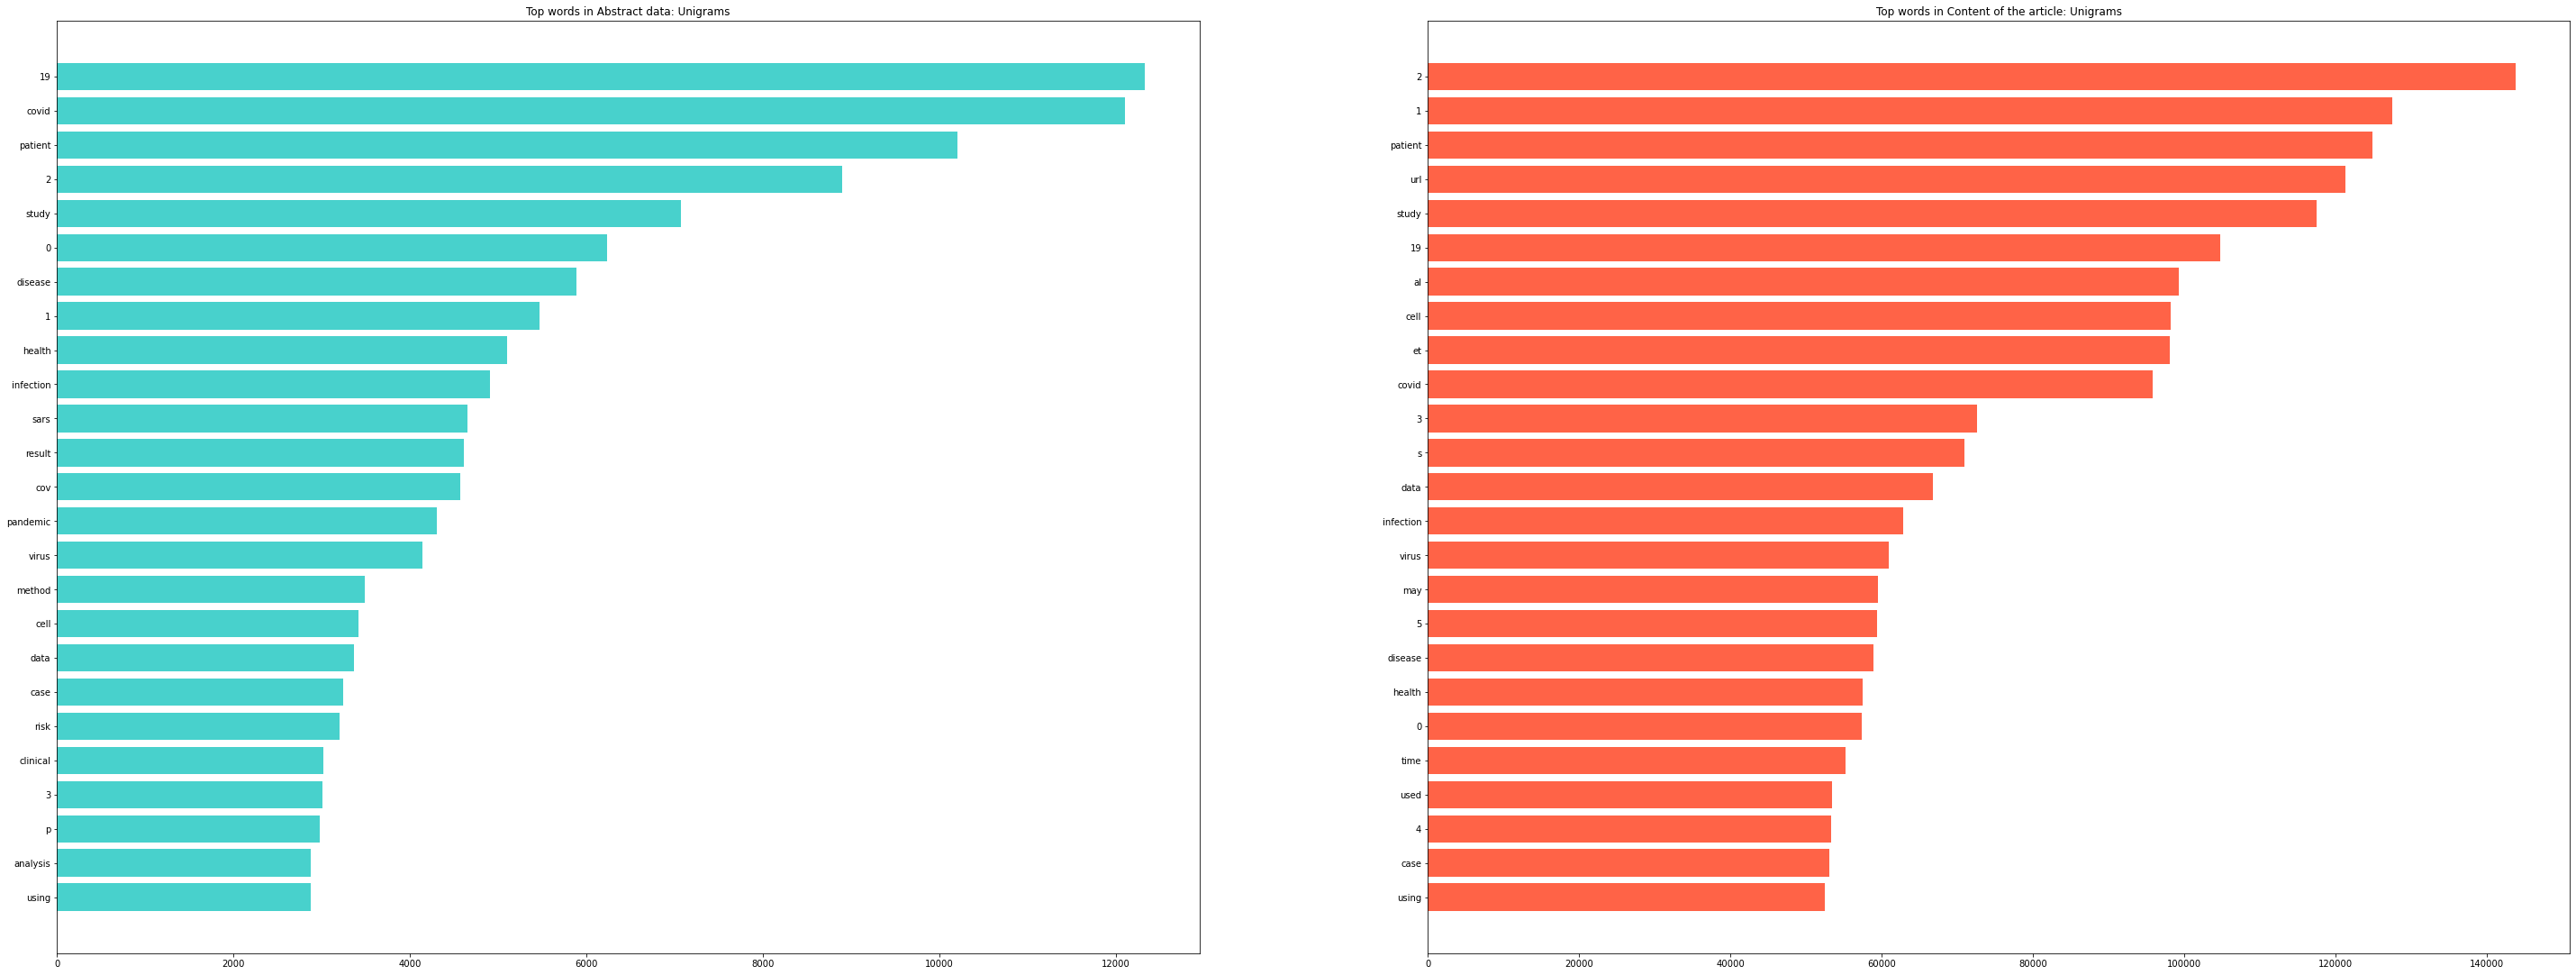

In [40]:
# plotting graph of Unigrams Sincere words 
plt.subplot(1, 2, 1)
word_freq_plot(unigrams_abstract, 'Abstract data: Unigrams', 'mediumturquoise')

# plotting graph of Unigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(unigrams_body, 'Content of the article: Unigrams', 'tomato')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

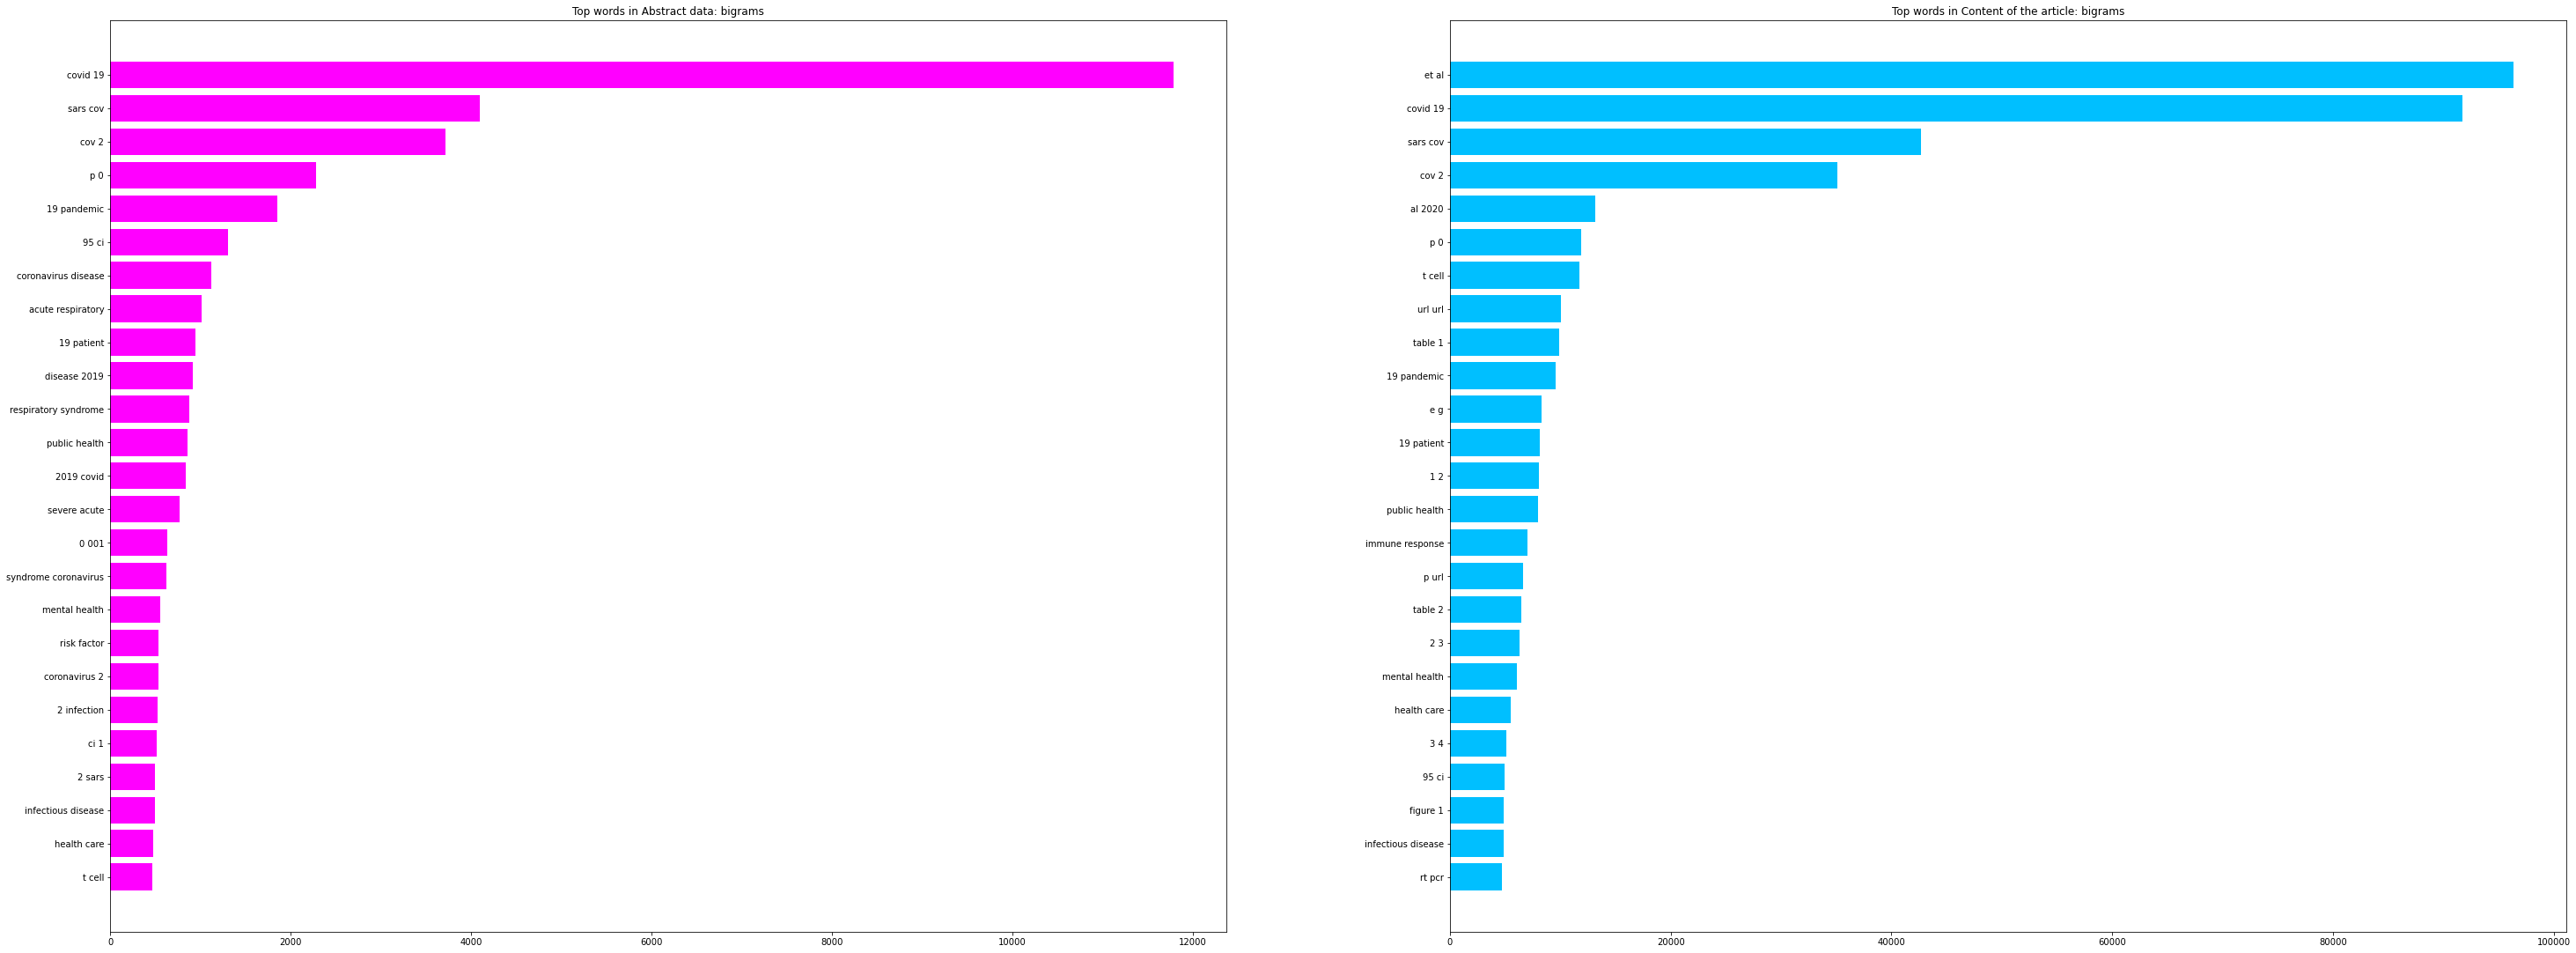

In [41]:
# plotting graph of Bigrams Sincere words
plt.subplot(1, 2, 1)
word_freq_plot(bigrams_abstract, 'Abstract data: bigrams', 'magenta')

# plotting graph of Bigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(bigrams_body, 'Content of the article: bigrams', 'deepskyblue')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

### 2.4 Functions to create sentences and preprocess them (To be used in word2vec model)

In [42]:
def split_sentences(article):
    """Takes in the articles and gives out a list of sentence in those articles all using nltk package
    
    Args:
        A single article from the data frame    
    Returns:
        list: list of sentences in that article
    """
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    list_df = []
    marked_sentences = '***'.join(tokenizer.tokenize(article))
    marked_sentences = re.sub(r"(\[[0-9]*\])",'',marked_sentences) #remove the citations 
    marked_sentences = re.sub(r"(\([0-9]*\))",'',marked_sentences)
    list_df  = marked_sentences.split('***')
    return list_df

In [43]:
def apply_all_sent_token(doc):
    """Takes in the articles filters out stop words and words with length <= 2 
    
    Args:
        A single article from the data frame    
    Returns:
        list: list of tokens which were not removed
    """
    
    list_all_tokens = []
    all_sent = [nltk.word_tokenize(sents) for sents in doc]
    for one_sent in all_sent:
        filtered_tokens = []
        filtered_tokens =[words for words in one_sent if words not in stop_words]
        custom_removed_tokens = [words for words in filtered_tokens if words not in ['.','shown','fig.','figure']] #remove custom stop words
        custom_removed_tokens = [words for words in custom_removed_tokens if len(words) > 2]
        list_all_tokens.append(custom_removed_tokens)
    return list_all_tokens

In [44]:
def preprocess_sentences(df):
    """Doing the preprocessing of the data
    
    Args:
        df (pandas dataframe): dataframe containing articles and sentences    
    Returns:
        df (pandas dataframe): dataframe of preprocessed sentence with its tokens
    """
    
    # Splits the data into sentences
    df_sent = df['body_text'].apply(lambda x: split_sentences(x))
    
    # Changes upper case into lower case
    df_lower = df_sent.apply(lambda doc: [sent.lower() if type(sent) == str else sent for sent in doc])
    
    #remove punctuations
    df_clean = df_lower.apply(lambda doc: [re.sub(r"[^.a-z]",' ',sent) for sent in doc])
    
    # tokenize all the sentences 
    df_token = df_clean.apply(lambda doc:apply_all_sent_token(doc))
    
    # Add these to the data frame
    preprocess_df=pd.concat([df,df_sent],axis = 1)
    preprocess_df=pd.concat([preprocess_df, df_token], axis=1)
    preprocess_df.columns=['paper_id','original_body', 'abstract','preprocessed_abstract','preprocessed_body_text','sentences','token_sentences']
    return preprocess_df

In [45]:
def prepare_input_df(input_list):
    """Preparing the input questiions that are asked by users, to be passed into our model
    to find the 10 most similar sentences 1 from each articles
    
    Args:
        input question (list): list of sentences inputted by users
    
    Returns:
        df (pandas dataframe): dataframe of sentence with its tokens (user's questions)
    """
    input_df = pd.DataFrame()
   
    input_group = input_list  
                    
    input_tokens=[nltk.word_tokenize(sents) for sents in input_group]
    input_df['sentences']=[input_group]
    input_df['token_sentences']=[input_tokens]
    return input_df

In [46]:
def preprocess_data(df,number_of_artciles,input_list):
    
    # Calling preprocess_sentence function to get clean data
    preprocess_df=preprocess_sentences(df)
    
    # Calling prepare_input_df function to get the inputs cleaned
    input_df = prepare_input_df(input_list)
    
    #printing the results
    preprocess_df.head()
    input_df.head()
    return preprocess_df,input_df


In [47]:
# Generate a article dataframe using the relevant sentences and 

def generate_article_df(one_article_df):
    """Function to create a dataframe with only sentences and tokens of that sentence for 1 article
    
    Args:
        df (pandas dataframe): dataframe containing articles and sentences    
    Returns:
        df (pandas dataframe): dataframe of single article's sentence with its tokens
    """
    
    all_articles_relevant_sentences_list = []
    article_df = pd.DataFrame()
    article_df['sentences'] = one_article_df['sentences']
    article_df['token_sentences'] =  one_article_df['token_sentences']
    return article_df

In [48]:
def transform_input(input_df, start_input_index, end_input_index):
    """Function to transfrom the user input
    
    Args:
        df (pandas dataframe): dataframe containing user input from prepare_input_df function
    Returns:
        df (pandas dataframe): dataframe of single user's input sentence with its tokens 
    """
    input_list = [] 
    sent_list = []
    
    # Tokenizing the sentences in input_df
    for index in range(len(input_df.token_sentences.iloc[0])):
        input_list.append(input_df.token_sentences.apply(lambda x: x[index]))
    for index in range(len(input_df.sentences.iloc[0])):
        sent_list.append(input_df.sentences.apply(lambda x: x[index]))
    
    df = pd.DataFrame()    
    df = pd.concat(input_list, axis=1,ignore_index=True)
    df2=pd.concat(sent_list,axis=1,ignore_index=True)
    df=df.transpose()
    df2=df2.transpose()
    
    # Adding these 2 columns to input_transformed_df
    input_transformed_df = pd.concat([df2,df],axis=1)
    input_transformed_df.columns=['sentences','token_sentences']
    input_transformed_df = input_transformed_df.loc[start_input_index:end_input_index]

    return input_transformed_df

## 3. Model Creation and tuning

### 3.1 Word2Vec model to get the most similar sentence 

In [79]:
# Run this only if you don't have this pretrained model available
# If you use this command it will download the model in "C:\Users\yash\gensim-data" something like this
# Now go to that folder and extract the zip file, you get a .bin file, now cut and paste this in your working directory

# If you don't wish to download it I have provided this model in the submission just copy paste it in your working folder

# Refer this documentation for word2vec https://radimrehurek.com/gensim/models/word2vec.html
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [49]:
# This will load the pretrained model
word2vec_model = KeyedVectors.load_word2vec_format('.\Saved_models\word2vec-google-news-300\GoogleNews-vectors-negative300.bin', binary =True)

In [50]:
def generate_word_embeddings(transformed_article_df,transformed_input_df):   
    """ Function to create word embeddings from the sentences 
    Args:
        df (pandas dataframe): dataframe of transformed articles
        df (pandas dataframe): dataframe of transformed inputs
    Returns:
        list: list of all the embeddings of articles
        list: list of all the embeddings from input
    """
    all_sentences = transformed_article_df[['token_sentences']]
    all_sentences_list = all_sentences.values.flatten().tolist()
    
    input_sentences = transformed_input_df[['token_sentences']]
    
    input_sentenes_list = input_sentences.values.flatten().tolist()
    
    all_sentences = all_sentences_list + input_sentenes_list
    
    document_frequency_dict, num_documnets = get_document_frequency(all_sentences)
    sentence_embeddings_list = average_word_embedding_cosine_similarity(transformed_article_df, word2vec_model,document_frequency_dict,num_documnets)
    input_embeddings_list = average_word_embedding_cosine_similarity(transformed_input_df, word2vec_model,document_frequency_dict,num_documnets)
    
    return sentence_embeddings_list,input_embeddings_list

In [51]:
def prepare_doc2vec_tagged_documents(article_df, transformed_input_df):
    """Function to create tags for all the articles
    
    Args:
        df (pandas dataframe): dataframe containing articles
        df (pandas dataframe): dataframe containing user input 
    Returns:
        list: list of all the labeled sentences
    """
    # Loading required columns to perform necessary function/changes
    article_sentences = article_df[['sentences']] 
    article_sentences_list = article_sentences.values.flatten().tolist()
    
    
    input_sentences = transformed_input_df[['sentences']]
    input_sentences_list = input_sentences.values.flatten().tolist()
   
    all_sentences_list = article_sentences_list + input_sentences_list


    corpus = all_sentences_list
    len(corpus)

    # Produce dictionary of sentence to id
    sentence_id = {sent : i for i, sent in enumerate(corpus)} #
    
    # Assign id to sentences
    article_df['qid1'] = article_df['sentences'].apply(lambda row : sentence_id[row])
    transformed_input_df['qid2'] = transformed_input_df['sentences'].apply(lambda row : sentence_id[row])
    
     # Doc2vec requires data as Tagged Documents with the tokenized sentence and the sentence id
    article_df['labeled_tokens_article'] = article_df.apply(lambda x: TaggedDocument(x.token_sentences, str(x.qid1)), axis=1)
    transformed_input_df['labeled_tokens_input'] = transformed_input_df.apply(lambda x: TaggedDocument(x.token_sentences, str(x.qid2)), axis=1)
    
    #Get all Tagged Documents
    labeled_article_sentences = article_df[['labeled_tokens_article']]  
    labeled_article_sentences_list = labeled_article_sentences.values.flatten().tolist()
    
    labeled_input_sentences = transformed_input_df[['labeled_tokens_input']]
    labeled_input_sentences_list = labeled_input_sentences.values.flatten().tolist()
    labeled_sentences= labeled_article_sentences_list + labeled_input_sentences_list
    
    return labeled_sentences

In [52]:
# Training the doc2vec model

def train_doc2vec_model(labeled_sentences):
    """Function to train a doc2vec model on the labeled sentences from articles
    
    Args:
        list: list of all the labeled sentences from articles
    Returns:
        model: return the trained model.
    """
    Model_path = os.path.join('Saved_models', 'word2vec')
    Model_name = "word2vec_D2V"
    fname = os.path.join(Model_path, Model_name)
    
    # If the model is already present at this directory then load it
    if os.path.exists(fname):
        model = Doc2Vec.load(fname)
    
    # Else we train the model again and then save it at that location
    else:
        model = Doc2Vec(labeled_sentences, dm=1, min_count=1, window=10,negative=5, vector_size=100, epochs=30)
    
        # Train our model for 30 epochs
        for epoch in range(30):
            model.train(labeled_sentences, epochs=model.epochs, total_examples=model.corpus_count)
        
        model.save(fname)
    return model

In [53]:
# Finding the cosine similarity with the inputs and text data

def doc2vec_cosine_similarity(article_df,transformed_input_df,doc2vec_model, start_input_index ,end_input_index):
    
    for index in range(start_input_index,end_input_index):
        name = "task_" + str(index+1)
        input_token = transformed_input_df.iloc[index]['token_sentences']
        article_df[name] = article_df.apply(lambda x: doc2vec_model.wv.n_similarity(x.token_sentences,input_token) if len(x.token_sentences) != 0 else 0, axis = 1)
    return article_df


In [54]:
# Generate relevant sentences per article matching the input using above geenrated functions

def doc2vec_per_article(one_article_df,transformed_input_df,threshold, start_input_index ,end_input_index):
    """Function to get the cosine similarity between the trained corpus and the input provided by user
    
    Args:
        df (pandas dataframe): dataframe containing articles
        df (pandas dataframe): dataframe containing user input
        value: threshold (minimum value of cosine similarity we would consider)
        value: starting index of the questions (in case user chooses to ask more then 1 question)
        value: ending index of the questions (in case user chooses to ask more then 1 question)
    Returns:
        list: list of the most relevant sentences from all the sentences in the articles (similar sentences)
    """
    
    # Calling above generated functions to get labled sentences and the model
    article_df = generate_article_df(one_article_df)
    labeled_sentences = prepare_doc2vec_tagged_documents(article_df,transformed_input_df)
    doc2vec_model = train_doc2vec_model(labeled_sentences)
    
    # Calling cosine similarity & find_top_relevant_sentences functions to get the most similar sentences from the corpus based on their cosine scores
    transformed_article_df=doc2vec_cosine_similarity(article_df,transformed_input_df,doc2vec_model,start_input_index ,end_input_index)
    relevant_sentences_one_article= find_top_relevant_sentences(transformed_article_df,transformed_input_df,threshold, start_input_index ,end_input_index) 
    
    return relevant_sentences_one_article

In [55]:
def word2vec_per_article(one_article_df,transformed_input_df,threshold,start_input_index ,end_input_index):
    """Function to get the cosine similarity between the trained corpus and the input provided by user
    
    Args:
        df (pandas dataframe): dataframe containing only 1 article's data
        df (pandas dataframe): dataframe containing user input
        value: threshold (minimum value of cosine similarity we would consider)
        value: starting index of the questions (in case user chooses to ask more then 1 question)
        value: ending index of the questions (in case user chooses to ask more then 1 question)
    Returns:
        list: list of the most relevant sentences from all the sentences in the articles (similar sentences)
    """
    
    # Calling above generated functions to get labled sentences and generate its word embeddings with word2vec
    article_df = generate_article_df(one_article_df)
    sentence_embeddings_list,input_embeddings_list= generate_word_embeddings(article_df,transformed_input_df)
    
    # Calling cosine similarity & find_top_relevant_sentences functions to get the most similar sentences from the corpus based on their cosine scores
    transformed_article_df=generate_cosin_similarity(article_df,sentence_embeddings_list,input_embeddings_list)
    relevant_sentences_one_article = find_top_relevant_sentences(transformed_article_df,transformed_input_df,threshold, start_input_index ,end_input_index)
    
    return relevant_sentences_one_article
    

In [56]:
def find_top_relevant_sentences(article_df,input_transformed_df,threshold,start_input_index ,end_input_index):
    """Function to get the cosine similarity between the trained corpus and the input provided by user
    
    Args:
        df (pandas dataframe): dataframe containing article data
        df (pandas dataframe): dataframe containing user input
        value: threshold (minimum value of cosine similarity we would consider)
        value: starting index of the questions (in case user chooses to ask more then 1 question)
        value: ending index of the questions (in case user chooses to ask more then 1 question)
    Returns:
        list: list of the most relevant sentences from all the sentences in the articles (similar sentences)
    """
    
    relevant_sentences_df = pd.DataFrame()
    deduplicated_relevante_top_sentences = pd.DataFrame()
    final_relevant_sentences_list = []
    tmp_final=pd.DataFrame(columns={'sentences','score'})
    
    for index in range(start_input_index,end_input_index): 
        name = "task_" + str(index+1)
        
        #sorting and select the top 5 sentences
        tmp_df=article_df.sort_values(name, inplace = False, ascending=False).head(5) 
        tmp2_df = tmp_df[['sentences',name]]
        tmp2_df = tmp2_df.rename(columns={name : "score"})
        
        #concatinate all the sentences and score and scores
        tmp_final=tmp_final.append(tmp2_df, ignore_index=True) 
    
    relevant_sentences_df=tmp_final.sort_values('score',inplace = False, ascending = False) #sorting
    
    #dropping duplicates
    deduplicated_relevante_top_sentences = relevant_sentences_df.drop_duplicates('sentences',keep='first') 
    deduplicated_relevante_top_sentences['score'] = pd.to_numeric(deduplicated_relevante_top_sentences['score'],errors='coerce')
    
    final_relevante_sentences=deduplicated_relevante_top_sentences[deduplicated_relevante_top_sentences.score > threshold]
    
    return final_relevante_sentences 


In [57]:
def find_relevant_sentences_all_articles(preprocess_df,input_df, threshold, start_input_index,end_input_index):
    
    all_relevant_sentences_list = []
    transformed_input_df = transform_input(input_df,start_input_index,end_input_index)
    
    for index in range(len(preprocess_df)):
        one_article_relevant_sentences_list = []
        one_article_df=preprocess_df.iloc[index]
        
        relevant_sentences_one_article = word2vec_per_article(one_article_df,transformed_input_df,threshold,start_input_index ,end_input_index) #using word2vec instead of doc2vec
        
        for i in range(len(relevant_sentences_one_article)):
            one_article_relevant_sentences_list.append(relevant_sentences_one_article.iloc[i]['sentences'])
        
        all_relevant_sentences_list.append(one_article_relevant_sentences_list)
    
    preprocess_df['extracted_relevant_sentences_word2vec_dianostics_results'] = all_relevant_sentences_list
    return preprocess_df

In [58]:
# Created this function with the help of stackoverflow and geekforgeeks sites

def generate_cosin_similarity(transformed_article_df,sentence_embeddings_list,input_embeddings_list):
    for index in range(len(input_embeddings_list)): #len(input_embeddings_list)
        cosine_similarity = []
        name = "task_" + str(index+1)
        
        for index2 in range(len(sentence_embeddings_list)):
            one_sentence_embeddings = sentence_embeddings_list[index2]
            input_embeddings = input_embeddings_list[index]
            
            if sum(one_sentence_embeddings) != 0 and sum(input_embeddings)!= 0:
                
                #print(calculate_modified_cosine_similarity(one_sentence_embeddings,input_embeddings))
                cosine_similarity.append(calculate_cosine_similarity(one_sentence_embeddings,input_embeddings))
            
            else: 
                #print(0)
                cosine_similarity.append(0)
                
        #print(len(cosine_similarity))
        transformed_article_df[name]= cosine_similarity 
    #cosine_df[name]=pd.Series(cosine_similarity)
    
    return transformed_article_df

In [59]:
def get_document_frequency(all_sentences_list):
    """Iterate through all sentences in dataframe and create a dictionary 
    mapping tokens to the number of sentences in our corpus they appear in
    
    Args:
        df (pandas dataframe): dataframe of sentence pairs with their similarity scores
        
    Returns:
        document_frequency_dict (dictionary): mapping from tokens to number of sentences they appear in
        n (int): number of sentences in the corpus
    """
    document_frequency_dict = {}
    all_sentences = []
    all_sentences = all_sentences_list     
    n = len(all_sentences)

    for s in all_sentences:
        for token in set(s):
            document_frequency_dict[token] = document_frequency_dict.get(token, 0) + 1

    return document_frequency_dict, n

In [60]:
def average_word_embedding_cosine_similarity(df, embedding_model, document_frequencies,num_documnets, rm_stopwords=False):
    """Calculate the cosine similarity between TF-IDF weighted averaged embeddings
    
    Args:
        df (pandas dataframe): dataframe as provided by the nlp_utils
        embedding_model: word embedding model
        rm_stopwords (bool): whether to remove stop words (True) or not (False)
    
    Returns:
        list: predicted values for sentence similarity of test set examples
    """
   
    sentence_embedding = df.apply(lambda x: average_sentence_embedding(x.token_sentences, embedding_model,document_frequencies, num_documnets), axis=1)

    sentence_embedding_list = sentence_embedding.tolist()

    return sentence_embedding_list

In [61]:
def calculate_cosine_similarity(embedding1, embedding2):
    """Calculate cosine similarity between two embedding vectors
    
    Args:
        embedding1 (list): embedding for the first sentence
        embedding2 (list): embedding for the second sentence
    
    Returns:
        list: cosine similarity value between the two embeddings
    """
    # distance.cosine calculates cosine DISTANCE, so we need to
    # return 1 - distance to get cosine similarity
    cosine_similarity = 1 - distance.cosine(embedding1, embedding2)
    return cosine_similarity

In [62]:
def average_sentence_embedding(tokens, embedding_model,document_frequencies, num_documents):
    """Calculate TF-IDF weighted average embedding for a sentence
    
    Args:
        tokens (list): list of tokens in a sentence
        embedding_model: model to use for word embedding (word2vec, glove, fastText, etc.)
    
    Returns:
        list: vector representing the sentence
    """
    # Throw away tokens that are not in the embedding model
    tokens = [i for i in tokens if i in embedding_model]

    if len(tokens) == 0:
        return []

    # We will weight by TF-IDF. The TF part is calculated by:
    # (# of times term appears / total terms in sentence)
    count = Counter(tokens)
    token_list = list(count)
    term_frequency = [count[i] / len(tokens) for i in token_list]

    #print(num_documents)
    # Now for the IDF part: LOG(# documents / # documents with term in it)
    inv_doc_frequency = [
        math.log(num_documents / (document_frequencies.get(i, 0) + 1)) for i in count
    ]

    # Put the TF-IDF together and produce the weighted average of vector embeddings
    word_embeddings = [embedding_model[token] for token in token_list]
    weights = [term_frequency[i] * inv_doc_frequency[i] for i in range(len(token_list))]
    return list(np.average(word_embeddings, weights=weights, axis=0))

## Run Methods

#### Settings to be passed into Word2Vec models

In [63]:
# loading preprocessed data from saved file
df = pd.read_csv('.\Data\Preprocessed_covid_data')
df.head()

,Unnamed: 0,cord_uid,title,abstract,publish_time,authors,journal,pdf_json_files,pmc_json_files,url,body_text,preprocessed_abstract,preprocessed_body_text
0,0,emd6te1x,Religious Education in Catholic Schools: Troub...,Does Religious Education have a future? It cou...,2020-11-07,"Dineen, Fiona",Irish and British Reflections on Catholic Educ...,document_parses/pdf_json/4ea7c6a0db4dff676b5c2...,document_parses/pmc_json/PMC7980965.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Introduction: Setting the Scene\n\nIn the past...,doe religious education future it argued conte...,introduction setting scene in past decade irel...
1,1,wnnfcc01,Die Wirtschaftspolitik zurückgewinnen,"Die genauere Analyse in diesem Kapitel zeigt, ...",2021-02-23,"Oberholzer, Basil",Die globale Armut bek&#x000e4;mpfen,document_parses/pdf_json/b5c562cc1b54f4e6ca3c5...,document_parses/pmc_json/PMC7972609.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,\n\neinem Land den notwendigen Raum für seine ...,die genauere analyse diesem kapitel zeigt das ...,einem land den notwendigen raum für seine wirt...
2,2,gn2bwgt2,Maternal and neonatal data collection systems ...,BACKGROUND: Most post-licensure vaccine pharma...,2021-03-17,"Berrueta, Mabel; Ciapponi, Agustin; Bardach, A...",BMC Pregnancy Childbirth,document_parses/pdf_json/ccf579bc93d39ce33e3eb...,document_parses/pmc_json/PMC7968860.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33731029/;...,Background\n\nSpontaneous or passive reporting...,background most post licensure vaccine pharmac...,background spontaneous passive reporting syste...
3,3,4ueeiewe,Romiplostim in children with newly diagnosed o...,Immune thrombocytopenia (ITP) is a disease of ...,2021-07-26,"Grainger, John D.; Kühne, Thomas; Hippenmeyer,...",Ann Hematol,document_parses/pdf_json/caecb12b9188ee33c3b49...,document_parses/pmc_json/PMC8310729.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/34308495/;...,Introduction\n\nPrimary immune thrombocytopeni...,immune thrombocytopenia itp disease heterogeno...,introduction primary immune thrombocytopenia i...
4,4,evhj17n7,Psychological Impact on the Nursing Profession...,Background: The COVID-19 pandemic is a public ...,2021-01-12,"Del Pozo-Herce, Pablo; Garrido-García, Rebeca;...",Int J Environ Res Public Health,document_parses/pdf_json/48d82b7161254e4dc4f39...,document_parses/pmc_json/PMC7827934.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33445563/;...,"Introduction\n\nIn December 2019, the first ou...",background the covid 19 pandemic public health...,introduction in december 2019 first outbreak s...


In [85]:
# Taking user's input to get the question then change it to list to pass into our "prepare_input_df" function
num = input("Please enter number of questions you want to ask.")

input_list1= []
for i in range(int(num)):
    sentence = input()
    
    # Adding this 1 question for generalizing the input
    s1 = "What is covid-19?"
    input_list1.append(s1)
    input_list1.append(sentence)
    
input_list1

Please enter number of questions you want to ask.3
How is covid-19 spreading?
What can we do to stop it?
How is it spreading so fast?


['What is covid-19?',
 'How is covid-19 spreading?',
 'What is covid-19?',
 'What can we do to stop it?',
 'What is covid-19?',
 'How is it spreading so fast?']

In [86]:
number_of_articles = df.count()
threshold = 0.4 #threshold for doc2vec cosin similarity 
start_input_index= 0 #start index for particular input query user's input
end_input_index = int(num) #end index for particular input search query user's inputs (if user enters 3 queries then its index will be 0,1,2 )
  
subset_df_covid = df[['cord_uid','body_text','abstract','preprocessed_abstract','preprocessed_body_text']]
subset_df_covid.head()

,cord_uid,body_text,abstract,preprocessed_abstract,preprocessed_body_text
0,emd6te1x,Introduction: Setting the Scene\n\nIn the past...,Does Religious Education have a future? It cou...,doe religious education future it argued conte...,introduction setting scene in past decade irel...
1,wnnfcc01,\n\neinem Land den notwendigen Raum für seine ...,"Die genauere Analyse in diesem Kapitel zeigt, ...",die genauere analyse diesem kapitel zeigt das ...,einem land den notwendigen raum für seine wirt...
2,gn2bwgt2,Background\n\nSpontaneous or passive reporting...,BACKGROUND: Most post-licensure vaccine pharma...,background most post licensure vaccine pharmac...,background spontaneous passive reporting syste...
3,4ueeiewe,Introduction\n\nPrimary immune thrombocytopeni...,Immune thrombocytopenia (ITP) is a disease of ...,immune thrombocytopenia itp disease heterogeno...,introduction primary immune thrombocytopenia i...
4,evhj17n7,"Introduction\n\nIn December 2019, the first ou...",Background: The COVID-19 pandemic is a public ...,background the covid 19 pandemic public health...,introduction in december 2019 first outbreak s...


In [87]:
preprocess_df, input_df = preprocess_data(subset_df_covid,number_of_articles, input_list1)
preprocess_df.head()

,paper_id,original_body,abstract,preprocessed_abstract,preprocessed_body_text,sentences,token_sentences
0,emd6te1x,Introduction: Setting the Scene\n\nIn the past...,Does Religious Education have a future? It cou...,doe religious education future it argued conte...,introduction setting scene in past decade irel...,[Introduction: Setting the Scene\n\nIn the pas...,"[[introduction, setting, scene, past, decade, ..."
1,wnnfcc01,\n\neinem Land den notwendigen Raum für seine ...,"Die genauere Analyse in diesem Kapitel zeigt, ...",die genauere analyse diesem kapitel zeigt das ...,einem land den notwendigen raum für seine wirt...,[\n\neinem Land den notwendigen Raum für seine...,"[[einem, land, den, notwendigen, raum, seine, ..."
2,gn2bwgt2,Background\n\nSpontaneous or passive reporting...,BACKGROUND: Most post-licensure vaccine pharma...,background most post licensure vaccine pharmac...,background spontaneous passive reporting syste...,[Background\n\nSpontaneous or passive reportin...,"[[background, spontaneous, passive, reporting,..."
3,4ueeiewe,Introduction\n\nPrimary immune thrombocytopeni...,Immune thrombocytopenia (ITP) is a disease of ...,immune thrombocytopenia itp disease heterogeno...,introduction primary immune thrombocytopenia i...,[Introduction\n\nPrimary immune thrombocytopen...,"[[introduction, primary, immune, thrombocytope..."
4,evhj17n7,"Introduction\n\nIn December 2019, the first ou...",Background: The COVID-19 pandemic is a public ...,background the covid 19 pandemic public health...,introduction in december 2019 first outbreak s...,"[Introduction\n\nIn December 2019, the first o...","[[introduction, december, first, outbreak, sar..."


In [88]:
final_preprocess_df = find_relevant_sentences_all_articles(preprocess_df,input_df,threshold,start_input_index ,end_input_index)
final_preprocess_df.head()

,paper_id,original_body,abstract,preprocessed_abstract,preprocessed_body_text,sentences,token_sentences,extracted_relevant_sentences_word2vec_dianostics_results
0,emd6te1x,Introduction: Setting the Scene\n\nIn the past...,Does Religious Education have a future? It cou...,doe religious education future it argued conte...,introduction setting scene in past decade irel...,[Introduction: Setting the Scene\n\nIn the pas...,"[[introduction, setting, scene, past, decade, ...",[If education were really understood as the pr...
1,wnnfcc01,\n\neinem Land den notwendigen Raum für seine ...,"Die genauere Analyse in diesem Kapitel zeigt, ...",die genauere analyse diesem kapitel zeigt das ...,einem land den notwendigen raum für seine wirt...,[\n\neinem Land den notwendigen Raum für seine...,"[[einem, land, den, notwendigen, raum, seine, ...",[]
2,gn2bwgt2,Background\n\nSpontaneous or passive reporting...,BACKGROUND: Most post-licensure vaccine pharma...,background most post licensure vaccine pharmac...,background spontaneous passive reporting syste...,[Background\n\nSpontaneous or passive reportin...,"[[background, spontaneous, passive, reporting,...",[Due to the fact that many of these GAIA defin...
3,4ueeiewe,Introduction\n\nPrimary immune thrombocytopeni...,Immune thrombocytopenia (ITP) is a disease of ...,immune thrombocytopenia itp disease heterogeno...,introduction primary immune thrombocytopenia i...,[Introduction\n\nPrimary immune thrombocytopen...,"[[introduction, primary, immune, thrombocytope...","[Furthermore, corticosteroids can cause a rang..."
4,evhj17n7,"Introduction\n\nIn December 2019, the first ou...",Background: The COVID-19 pandemic is a public ...,background the covid 19 pandemic public health...,introduction in december 2019 first outbreak s...,"[Introduction\n\nIn December 2019, the first o...","[[introduction, december, first, outbreak, sar...",[Factors were related to the fear of becoming ...


Now we got the most similar sentences from all the articles, we just need to arrange all these articles based on their cosine similarities with the input for that we will use new doc2vec model

### Doc2Vec model from Gensim

Only run this piece of code if you have high end pc or laptop because it took me 3-4 hours on my 32gb ram and 8gb Graphics card to train Doc2vec model on my corpus data.

And at the end didn't get very good accuracy so moved on to sentence trnasformation technique.

In [89]:
def tag_tokenize(df):
    
    # Tokenization of each article's preprocessed_body_text
    tokenized_sent = []
    paras = df.astype('str')
    
    for s in paras:
        tokenized_sent.append(word_tokenize(s.lower()))
    
    # We need to convert these into tagged or labeled data to use Docd2vec
    tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

    return tagged_data

In [90]:
def get_predictions(inputs, model):
    # Convert list to str
    input_str = ' '.join([str(elem) for elem in input_list1])
    
    # Tokenizing the input
    test_doc = word_tokenize(input_str.lower())
    test_doc_vector = model.infer_vector(test_doc)
    
    # doing the predictions by finding top 10 cosine similarity
    predictions = model.docvecs.most_similar(positive = [test_doc_vector])
    
    # Saving these into a dataframe
    pred_df = pd.DataFrame(predictions)
    pred_df.rename({0 : 'index'}, inplace = True, axis=1)
    pred_df.rename({1 : 'cos_sim'}, inplace = True, axis=1)
    
    return pred_df

In [91]:
# Function to get most similar articles based on the cosine similarity

def get_similar_articles(predicted_df, data_df):
    
    # Creating a subset of the dataframe since we just need the most similar articles abstract and body
    data_df = data_df[['original_body','abstract','extracted_relevant_sentences_word2vec_dianostics_results']]
    cosine_similarity = predicted_df['cos_sim']
    
    # Running a loop based on the predictions tags we compare it with the index of the articles 
    # now the tags start with 1 and index starts with 0, so we are subtracting 1 from tags
    similar_articles = pd.DataFrame()

    for i in (predicted_df['index'] - 1) :

        similar_articles = similar_articles.append(data_df.iloc[i])
    
    # Adding the cosine similarity to the "similar_articles" dataframe
    similar_articles = similar_articles.reset_index()
    
    # Adding 1 to index to match the tagged number since it started with 1 and not 0
    similar_articles['index'] += 1
    similar_articles.rename({'index' : 'Tags Generated by Doc2Vec for articles'}, inplace = True, axis=1)
    
    # Adding the final column with the similarity score
    similar_articles['cosine_similarity'] = predicted_df['cos_sim']
        
    return similar_articles

### Lets see how our abstract model does:

In [ ]:
# Giving user an chance to choose which model they want to use for predictions (one that is trained on abstract or body_text)
model_choose = input("Please enter 1) If you want to use model trained on abstarct data or 2) If you want to use model trained on body_text:- ")

In [ ]:
# If user choose 1 then try to load abstract model or train it
if int(model_choose) == 1:
    
    Model_path = os.path.join('Saved_models', 'Doc2vec')
    Model_name = "Abstarct_D2V"
    fname = os.path.join(Model_path, Model_name)
    
    # Check if there is a already trained model available, if there is load it
    if os.path.exists(fname):
        print("Loading abstarct model")
        model1 = Doc2Vec.load(fname)
    
    # Else we train a new model and save it at that location
    else:
        # Calling "tag_tokenize" function to get the tagged documents which needs to be fed into doc2vec model
        tagged_articles = tag_tokenize(final_preprocess_df['preprocessed_abstract'])

        # Training the Doc2Vec model on our abstarct data/corpus
        model1 = Doc2Vec(tagged_articles, vector_size = 250, window = 10, min_count = 5, epochs = 100)
        print("saving abstract model")
        
        # If those folders exists then save the model directly otherwise create those folders and then save
        if os.path.exists(Model_path):
            model1.save(fname)
        else:
            os.makedirs(Model_path)
            model1.save(fname)

# If user choose 2 then try to load body_text model or train it
elif int(model_choose) == 2:
    
    Model_path = os.path.join('Saved_models', 'Doc2vec')
    Model_name = "Body_text_D2V"
    fname = os.path.join(Model_path, Model_name)
    
    # Check if there is a already trained model available, if there is load it
    if os.path.exists(fname):
        print("Loading body_text model")
        model1 = Doc2Vec.load(fname)
    
    # Else we train a new model and save it at that location
    else:
        # Calling "tag_tokenize" function to get the tagged documents which needs to be fed into doc2vec model
        tagged_articles = tag_tokenize(final_preprocess_df['preprocessed_body_text'])

        # Training the Doc2Vec model on our body_text data/corpus
        model1 = Doc2Vec(tagged_articles, vector_size = 250, window = 10, min_count = 5, epochs = 100)
        print("saving body_text model")
        
        # If those folders exists then save the model directly otherwise create those folders and then save
        if os.path.exists(Model_path):
            model1.save(fname)
        else:
            os.makedirs(Model_path)
            model1.save(fname)

In [ ]:
pred_df = get_predictions(input_list1 , model1)

In [ ]:
sim_df = get_similar_articles(pred_df, final_preprocess_df)

sim_df 

## Let see how model trained on body_text does

In [ ]:
# Giving user an chance to choose which model they want to use for predictions (one that is trained on abstract or body_text)
model_choose = input("Please enter 1) If you want to use model trained on abstarct data or 2) If you want to use model trained on body_text:- ")

In [ ]:
# If user choose 1 then try to load abstract model or train it
if int(model_choose) == 1:
    
    Model_path = os.path.join('Saved_models', 'Doc2vec')
    Model_name = "Abstarct_D2V"
    fname = os.path.join(Model_path, Model_name)
    
    # Check if there is a already trained model available, if there is load it
    if os.path.exists(fname):
        print("Loading abstarct model")
        model1 = Doc2Vec.load(fname)
    
    # Else we train a new model and save it at that location
    else:
        # Calling "tag_tokenize" function to get the tagged documents which needs to be fed into doc2vec model
        tagged_articles = tag_tokenize(final_preprocess_df['preprocessed_abstract'])

        # Training the Doc2Vec model on our abstarct data/corpus
        model1 = Doc2Vec(tagged_articles, vector_size = 250, window = 10, min_count = 5, epochs = 100)
        print("saving abstract model")
        
        # If those folders exists then save the model directly otherwise create those folders and then save
        if os.path.exists(Model_path):
            model1.save(fname)
        else:
            os.makedirs(Model_path)
            model1.save(fname)

# If user choose 2 then try to load body_text model or train it
elif int(model_choose) == 2:
    
    Model_path = os.path.join('Saved_models', 'Doc2vec')
    Model_name = "Body_text_D2V"
    fname = os.path.join(Model_path, Model_name)
    
    # Check if there is a already trained model available, if there is load it
    if os.path.exists(fname):
        print("Loading body_text model")
        model1 = Doc2Vec.load(fname)
    
    # Else we train a new model and save it at that location
    else:
        # Calling "tag_tokenize" function to get the tagged documents which needs to be fed into doc2vec model
        tagged_articles = tag_tokenize(final_preprocess_df['preprocessed_body_text'])

        # Training the Doc2Vec model on our body_text data/corpus
        model1 = Doc2Vec(tagged_articles, vector_size = 250, window = 10, min_count = 5, epochs = 100)
        print("saving body_text model")
        
        # If those folders exists then save the model directly otherwise create those folders and then save
        if os.path.exists(Model_path):
            model1.save(fname)
        else:
            os.makedirs(Model_path)
            model1.save(fname)

In [ ]:
pred_df = get_predictions(input_list1 , model1)

In [ ]:
sim_df = get_similar_articles(pred_df, final_preprocess_df)

sim_df

__Observation__:
- As you can see from cosine similarity, the abstarct model is performing very poorly.
- And the reason for this is because it has very small amount of data compared to body_text

## As you can see we were successfully able to get top 10 most similar articles and among them the most similar sentences.

#### Since we have achieved our goal and I have some free time to spare I'll give sentence transformation a go.

In [ ]:
Model_path = os.path.join('Saved_models', 'Sentence_trans')
Embedding_name = "sbert_embeddings"
Model_name = "sbert_model"
fname = os.path.join(Model_path, Model_name)
emb_path = os.path.join(Model_path, Embedding_name)

# Check if there is a already trained model/embeddings available, if there is load it
if (os.path.exists(fname)) and (os.path.exists(emb_path)) :
    print("Loading sentence transformation model and its embeddings")
    model = torch.load(fname)
    sentence_embeddings = torch.load(emb_path)
    
# Else we train a new model and save it at that location
else:
    print("Loading pre-trained SBERT model and generating embeddings using that model")
    
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    sentencelist = df['preprocessed_body_text'].tolist()
    sentence_embeddings = model.encode(sentencelist, convert_to_tensor=True)

        
    # If those folders exists then save the model directly otherwise create those folders and then save
    if os.path.exists(Model_path):
        
        print("Saving models ")
        torch.save(sentence_embeddings, emb_path)
        torch.save(model, fname)
    else:
        print("Saving models ")
        os.makedirs(Model_path)
        torch.save(sentence_embeddings, emb_path)
        torch.save(model, fname)

In [ ]:
print(np.shape(sentence_embeddings))

print(sentence_embeddings)

In [ ]:
# Function to get the cosine similarities between the question asked by user and the articles
# Inputs are the question asked by user and model varibale which we are using for finding the cos similarity
# output is a data frame that contains cosine similarity and index

def get_cos_sim(question , model):
    
    # Converting the question into vectors 
    test_emb = model.encode(question, convert_to_tensor=True)
    
    # Now calculating the cosine similarity with sentence_embedding, that we obtained earlier
    cos_sim = util.pytorch_cos_sim(sentence_embeddings, test_emb)
    
    # Converting tensor to panda dataframe
    pred_df = pd.DataFrame(cos_sim.numpy(), columns=['cosine_sim'])
    # Creating an index column
    pred_df['index'] = pred_df.index
    
    # Sorting them in decending order
    pred_df = pred_df.sort_values(by='cosine_sim', ascending=False)

    # Resetting its index to get the cosine similarity 
    pred_df = pred_df.reset_index(drop = True)

    print(pred_df.head(10))
    
    return pred_df

In [ ]:
# Convert list to str
input_str = ' '.join([str(elem) for elem in input_list1])

# Passing the input string we created in Doc2Vec from list
pred_df1 = get_cos_sim(input_str, model)

In [ ]:
# Function to print top-10 articles similar to the question asked by the user
# Takes the similarity data frame that we created using get_cos_sim function

def get_articles(pred_df):
    counter = 0
    for count in pred_df['index'][:10]:
        
        score = pred_df[pred_df['index'] == count]['cosine_sim']
        sim = torch.tensor(pred_df[pred_df['index'] == count]['cosine_sim'].values)
        max_elements, max_indices = torch.max(sim, dim=0)
        max_index = max_indices.item()
        
        print("------------------------------------------" + str(counter) +"----------------------------------------------")
        print("Cosine Similarity: " + str(pred_df.iloc[counter]['cosine_sim']) + "\n\nArticle index: " + str(count) + "\n\nTitle of the article: " +df.iloc[count]['title'] + "\n\nAbstract: " +df.iloc[count]['abstract'] + "\n\nBody Text: " + df.iloc[count]['body_text'] + "\n"  )    
        
        counter = counter + 1

In [ ]:
get_articles(pred_df1)